### Compositional analysis of the DMD Myeloid scRNA-Seq dataset using `milopy`
- **Developed by**: Christian Eger
- **Modified by**: Carlos Talavera-López
- **Talavera-López Lab - Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg**
- **Created on**: 231207
- **Last modified**: 240227

## Import statements and environment prep

In [1]:
import scvi
import rpy2
import numpy as np
import scanpy as sc
import pandas as pd
import pertpy as pt
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                 10.3.0
absl                NA
adjustText          1.1.1
appnope             0.1.4
arrow               1.3.0
arviz               0.18.0
asttokens           NA
attr                23.2.0
blitzgsea           NA
certifi             2024.02.02
cffi                1.16.0
chardet             5.2.0
charset_normalizer  3.3.2
chex                0.1.86
comm                0.2.2
contextlib2         NA
custom_inherit      2.4.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.1
decorator           5.1.1
decoupler           1.6.0
docrep              0.3.2
etils               1.7.0
exceptiongroup      1.2.1
executing           2.0.1
flax                0.8.4
fsspec              2024.5.0
h5py                3.11.0
idna                3.7
igraph              0.11.5
importlib_resources NA
ipykernel           6.29.4
ipywidgets          8.1.3
jax                 0.4.28
jaxlib    

In [3]:
rpy2.robjects.numpy2ri.activate()

## Data preparation

### Data loading

In [4]:
adata = sc.read_h5ad("../../data/heart_mm_nuclei-23-0092_scANVI-Myeloid_states_ctl240502.raw.h5ad")
adata

AnnData object with n_obs × n_vars = 41716 × 16060
    obs: 'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment'
    var: 'gene_ids-DMD_immune-DMD', 'feature_types-DMD_immune-DMD', 'genome-DMD_immune-DMD', 'mt-DMD_immune-DMD', 'ribo-DMD_immune-DMD', 'n_cells_by_counts-DMD_immune-DMD', 'mean_counts-DMD_immune-DMD', 'pct_dropout_by_counts-DMD_immune-DMD', 'total_counts-DMD

In [5]:
adata
adata.obs

orig.ident Age_group  BMI COVID_severity  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   
...                                      ...       ...  ...            ...   
TTTGGAGAGCGACTGA-1_2-MDX_MPC-1           NaN       NaN  NaN            NaN   
TTTGGAGAGGATAATC-1_2-MDX_MPC-1           NaN       NaN  NaN            NaN   
TTTGGAGTCTCGGCTT-1_2-MDX_MPC-1           NaN       NaN  NaN            NaN   
TTTGTTGAGATTCGAA-1_2-MDX_MPC-1           NaN       NaN  NaN            NaN   
TTTGTTGGTGATATAG-1_2-MDX_MPC-1           NaN       NaN  NaN            NaN   

                                  COVID_status Ethnicity Group  Sex  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   
...                                        ...       ...   ...  ...   
TTTGGAGAGCGACTGA-1_2-MDX_MPC-1             NaN       NaN   NaN  NaN   
TTTGGAGAGGATAATC-1_2-MDX_MPC-1             NaN       NaN   NaN  NaN   
TTTGGAGTCTCGGCTT-1_2-MDX_MPC-1             NaN       NaN   NaN  NaN   
TTTGTTGAGATTCGAA-1_2-MDX_MPC-1             NaN       NaN   NaN  NaN   
TTTGTTGGTGATATAG-1_2-MDX_MPC-1             NaN       NaN   NaN  NaN   

                                  annotation_broad annotation_detailed  ...  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW              NaN                 NaN  ...   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW              NaN                 NaN  ...   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW              NaN                 NaN  ...   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW              NaN                 NaN  ...   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW              NaN                 NaN  ...   
...                                            ...                 ...  ...   
TTTGGAGAGCGACTGA-1_2-MDX_MPC-1                 NaN                 NaN  ...   
TTTGGAGAGGATAATC-1_2-MDX_MPC-1                 NaN                 NaN  ...   
TTTGGAGTCTCGGCTT-1_2-MDX_MPC-1                 NaN                 NaN  ...   
TTTGTTGAGATTCGAA-1_2-MDX_MPC-1                 NaN                 NaN  ...   
TTTGTTGGTGATATAG-1_2-MDX_MPC-1                 NaN                 NaN  ...   

                                  pct_counts_ribo percent_mt2 percent_chrY  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW             NaN         NaN          NaN   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW             NaN         NaN          NaN   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW             NaN         NaN          NaN   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW             NaN         NaN          NaN   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW             NaN         NaN          NaN   
...                                           ...         ...          ...   
TTTGGAGAGCGACTGA-1_2-MDX_MPC-1                NaN         NaN          NaN   
TTTGGAGAGGATAATC-1_2-MDX_MPC-1                NaN         NaN          NaN   
TTTGGAGTCTCGGCTT-1_2-MDX_MPC-1                NaN         NaN          NaN   
TTTGTTGAGATTCGAA-1_2-MDX_MPC-1                NaN         NaN          NaN   
TTTGTTGGTGATATAG-1_2-MDX_MPC-1                NaN         NaN          NaN   

                                  XIST-counts S_score G2M_score _scvi_batch  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW         NaN     NaN       NaN        28.0   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW         NaN     NaN       NaN        29.0   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW         NaN     NaN       NaN        30.0   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW         

In [6]:
sc.pp.neighbors(adata, n_neighbors=150, use_rep="X_scANVI")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:41)


In [7]:
milo = pt.tl.Milo()
mdata = milo.load(adata)
mdata

MuData object with n_obs × n_vars = 41716 × 16060
  2 modalities
    rna:	41716 x 16060
      obs:	'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment'
      var:	'gene_ids-DMD_immune-DMD', 'feature_types-DMD_immune-DMD', 'genome-DMD_immune-DMD', 'mt-DMD_immune-DMD', 'ribo-DMD_immune-DMD', 'n_cells_by_counts-DMD_immune-DMD', 'mean_counts-DMD_immune-DMD', 'pct_dropout_by_counts-DMD_immune-DMD', 'total_counts-DMD_immune-DMD', 'vst.mean-MDX_MPC-DMD', 'vst.variance-MDX_MPC-DMD', 'vst.variance.expected-MDX_MPC-DMD', 'vst.variance.standardized-MDX_MPC-DMD', 'vst.variable-MDX_MPC-DMD', 'vst.mean-MDX_POOL_NEW-DMD', 'vst.variance-MDX_POOL_NEW-DMD', 'vst.variance.expected-MDX_POOL_NEW-DMD', 'vst.variance.standardized-MDX_POOL_NEW-DMD', 'vst.variable-MDX_POOL_NEW-DMD', 'vst.mean-MDX_MPC', 'vst.variance-MDX_MPC', 'vst.variance.expected-MDX_MPC', 'vst.variance.standardized-MDX_MPC', 'vst.variable-MDX_MPC', 'vst.mean-MDX_POOL_NEW', 'vst.variance-MDX_POOL_NEW', 'vst.variance.expected-MDX_POOL_NEW', 'vst.variance.standardized-MDX_POOL_NEW', 'vst.variable-MDX_POOL_NEW', 'name-pbmc_meyer'
      uns:	'C_scANVI_S1_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_source_colors', 'genotype_colors', 'hvg', 'neighbors', 'sample_colors', 'seed_labels_colors', 'umap'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
      obsp:	'distances', 'connectivities'
    milo:	0 x 0

In [8]:
milo.make_nhoods(mdata, prop=0.1)

/Users/cartalop/miniforge3/envs/milopy/lib/python3.10/site-packages/pertpy/tools/_milo.py:186: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.5834203 4.3309298 3.834348  ... 1.5956491 1.4842805 1.5915262]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs["nhood_ixs_refined"] == 1, "nhood_kth_distance"] = k_distances


## Defining of Neighbourhoods

In [9]:
adata.obsm["nhoods"]

<41716x3205 sparse matrix of type '<class 'numpy.float32'>'
	with 876037 stored elements in Compressed Sparse Row format>

Text(0, 0.5, '# neighbouthoods')

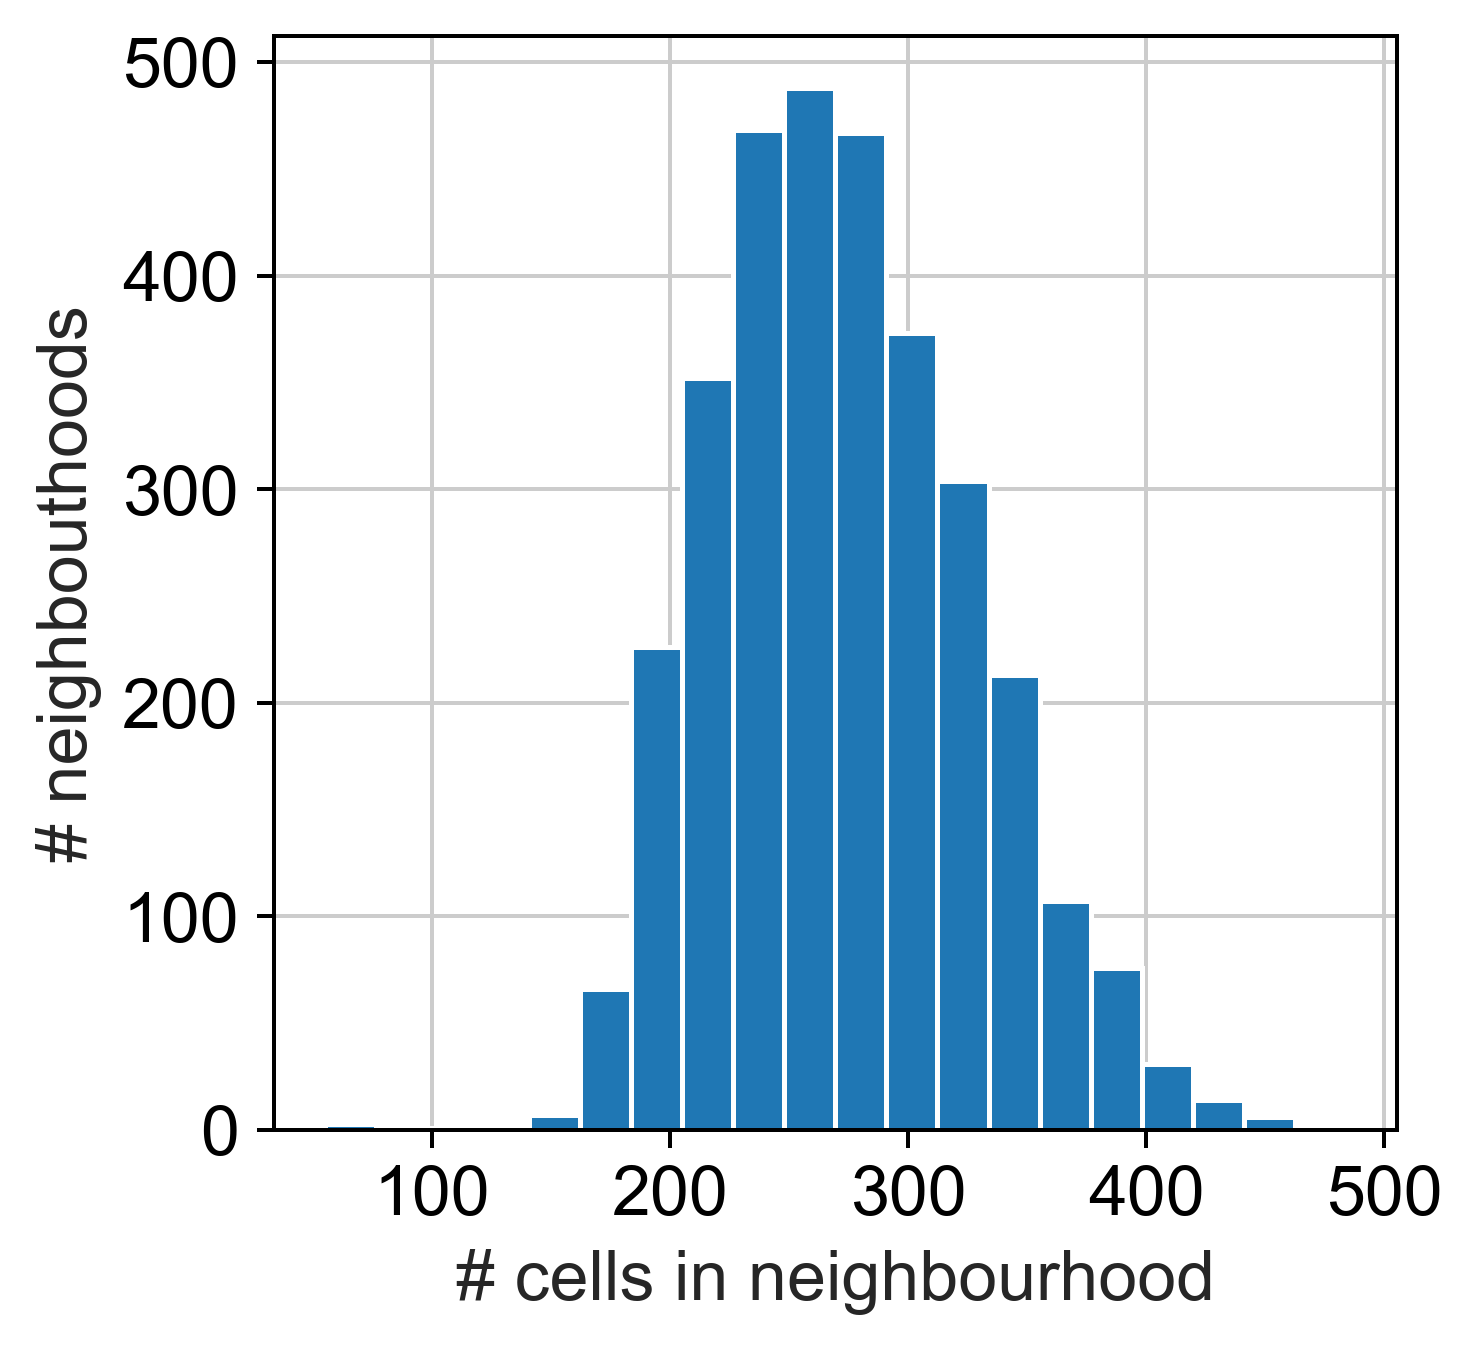

In [10]:
nhood_size = adata.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

In [11]:
np.median(nhood_size)

269.0

In [12]:
sc.pp.neighbors(adata, n_neighbors=150, use_rep="X_scANVI", key_added="milo")
milo.make_nhoods(mdata, neighbors_key="milo", prop=0.1)

computing neighbors
    finished: added to `.uns['milo']`
    `.obsp['milo_distances']`, distances for each pair of neighbors
    `.obsp['milo_connectivities']`, weighted adjacency matrix (0:00:31)


/Users/cartalop/miniforge3/envs/milopy/lib/python3.10/site-packages/pertpy/tools/_milo.py:186: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.5834203 4.3309298 3.834348  ... 1.5956491 1.4842805 1.5915262]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs["nhood_ixs_refined"] == 1, "nhood_kth_distance"] = k_distances


Text(0, 0.5, '# neighbouthoods')

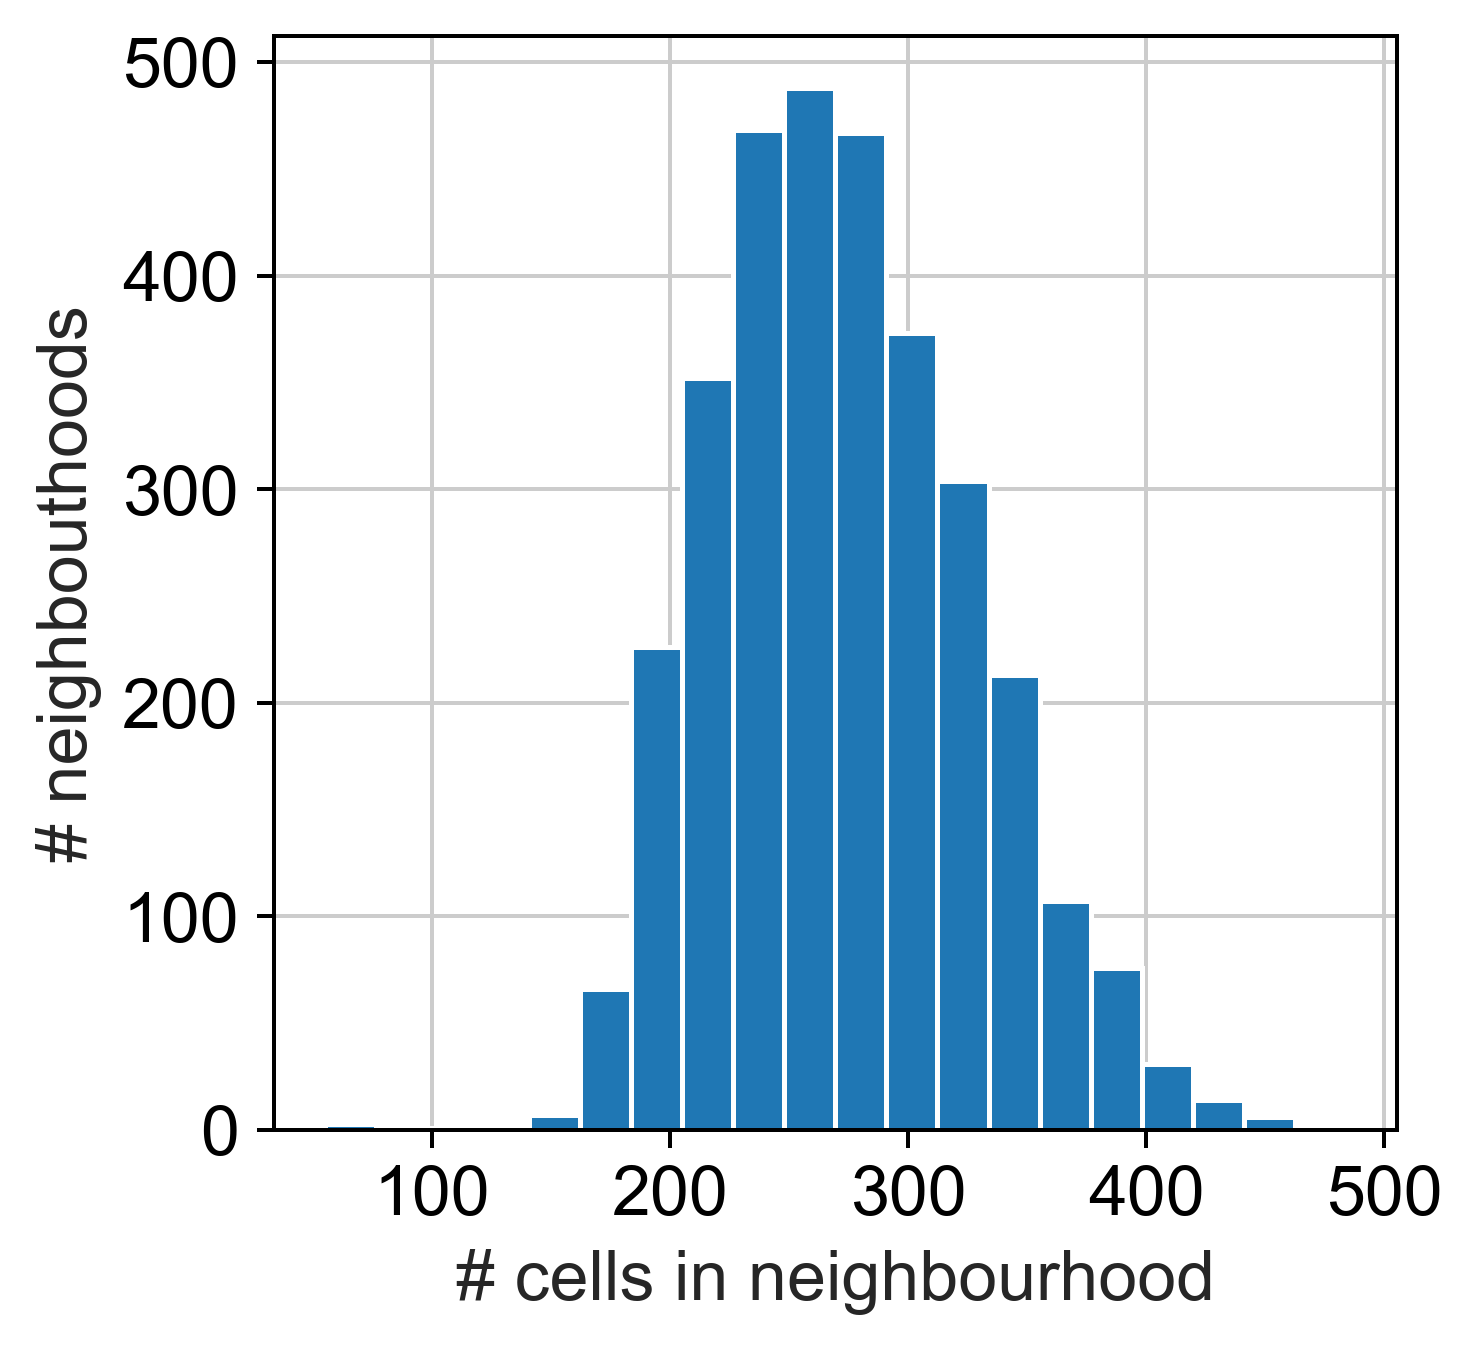

In [13]:
nhood_size = adata.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

In [14]:
np.median(nhood_size)

269.0

In [15]:
milo.count_nhoods(mdata, sample_col="sample")

/Users/cartalop/miniforge3/envs/milopy/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 41716 × 16060
  2 modalities
    rna:	41716 x 16060
      obs:	'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'gene_ids-DMD_immune-DMD', 'feature_types-DMD_immune-DMD', 'genome-DMD_immune-DMD', 'mt-DMD_immune-DMD', 'ribo-DMD_immune-DMD', 'n_cells_by_counts-DMD_immune-DMD', 'mean_counts-DMD_immune-DMD', 'pct_dropout_by_counts-DMD_immune-DMD', 'total_counts-DMD_immune-DMD', 'vst.mean-MDX_MPC-DMD', 'vst.variance-MDX_MPC-DMD', 'vst.variance.expected-MDX_MPC-DMD', 'vst.variance.standardized-MDX_MPC-DMD', 'vst.variable-MDX_MPC-DMD', 'vst.mean-MDX_POOL_NEW-DMD', 'vst.variance-MDX_POOL_NEW-DMD', 'vst.variance.expected-MDX_POOL_NEW-DMD', 'vst.variance.standardized-MDX_POOL_NEW-DMD', 'vst.variable-MDX_POOL_NEW-DMD', 'vst.mean-MDX_MPC', 'vst.variance-MDX_MPC', 'vst.variance.expected-MDX_MPC', 'vst.variance.standardized-MDX_MPC', 'vst.variable-MDX_MPC', 'vst.mean-MDX_POOL_NEW', 'vst.variance-MDX_POOL_NEW', 'vst.variance.expected-MDX_POOL_NEW', 'vst.variance.standardized-MDX_POOL_NEW', 'vst.variable-MDX_POOL_NEW', 'name-pbmc_meyer'
      uns:	'C_scANVI_S1_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_source_colors', 'genotype_colors', 'hvg', 'neighbors', 'sample_colors', 'seed_labels_colors', 'umap', 'nhood_neighbors_key', 'milo'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', 'nhoods'
      obsp:	'distances', 'connectivities', 'milo_distances', 'milo_connectivities'
    milo:	21 x 3205
      var:	'index_cell', 'kth_distance'
      uns:	'sample_col'

Text(0, 0.5, 'Mean # cells per sample in nhood')

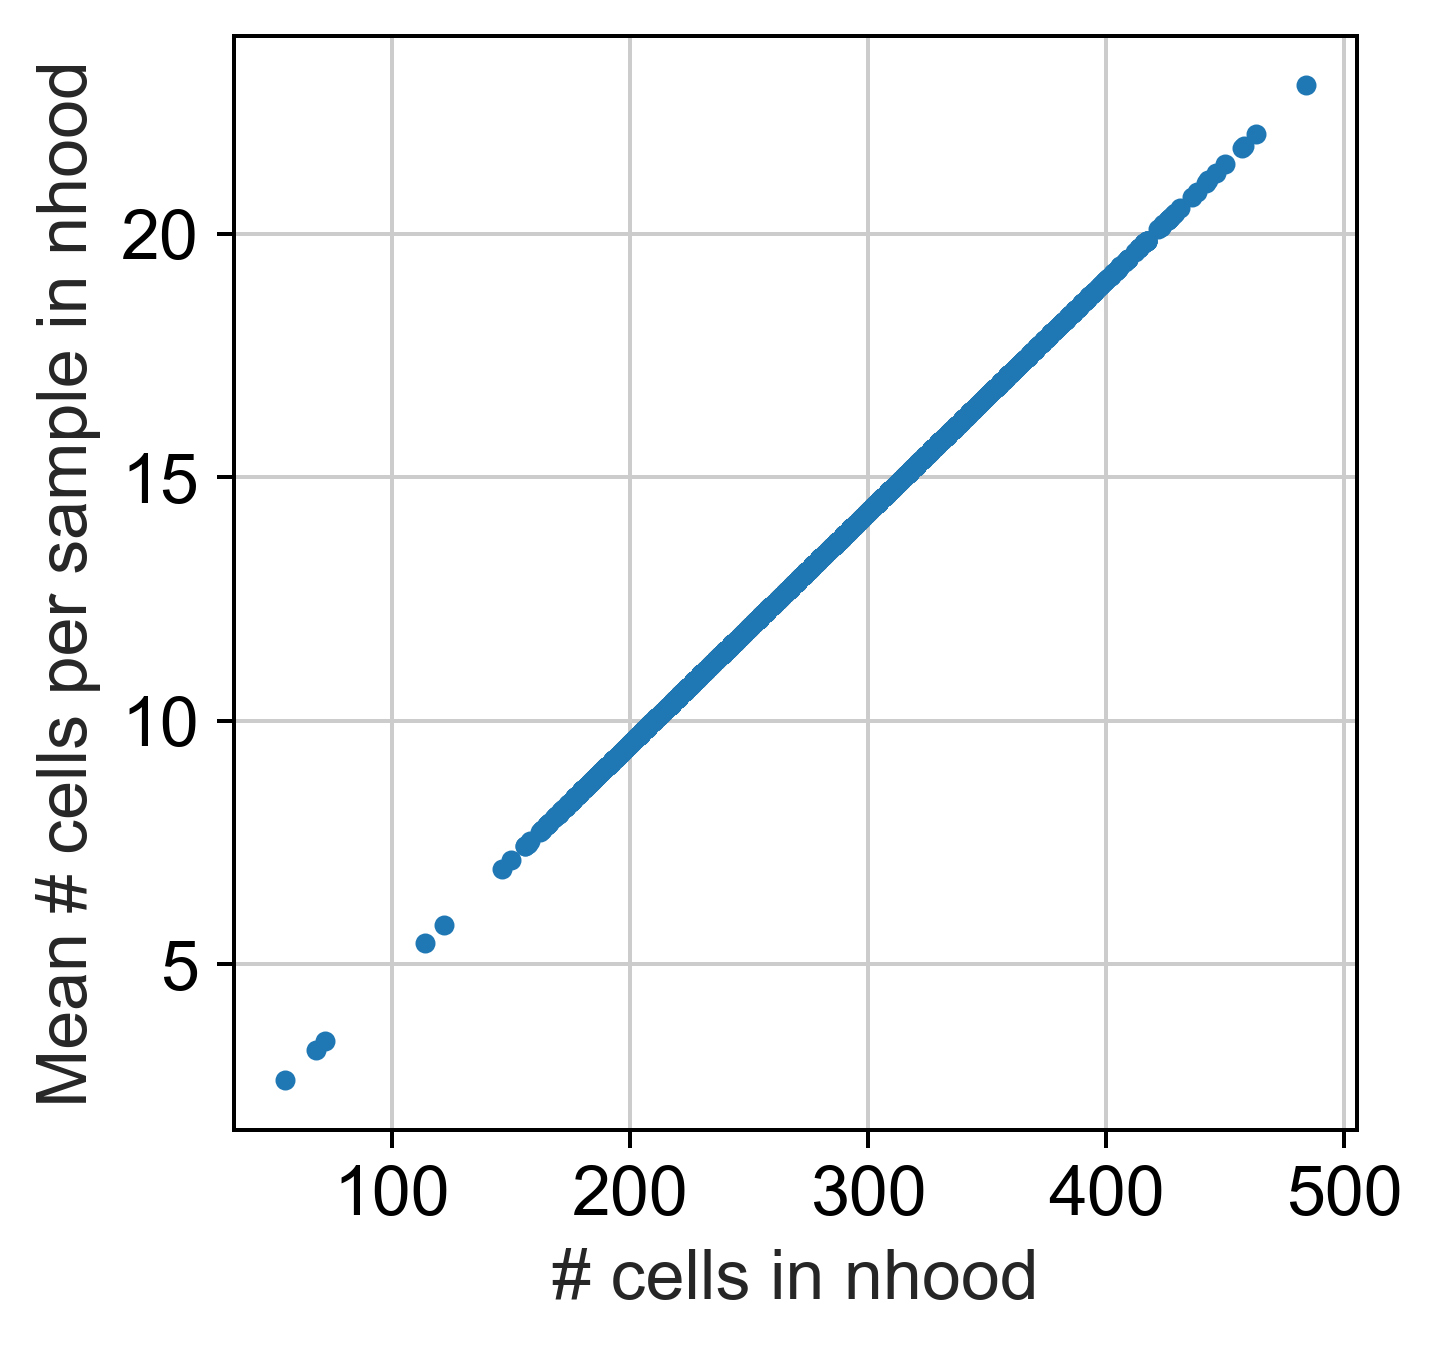

In [16]:
mean_n_cells = mdata["milo"].X.toarray().mean(0)
plt.plot(nhood_size, mean_n_cells, ".")
plt.xlabel("# cells in nhood")
plt.ylabel("Mean # cells per sample in nhood")

In [17]:
mdata["rna"].obs["genotype"].cat.categories

Index(['Mdx', 'MdxSCID', 'WT'], dtype='object')

In [18]:
milo.da_nhoods(
    mdata, design="~genotype", model_contrasts="genotypeWT-genotypeMdx"
)

#milo_results_healthy_iav = mdata["milo"].obs.copy()
#milo_results_healthy_iav

/Users/cartalop/miniforge3/envs/milopy/lib/python3.10/site-packages/pertpy/tools/_milo.py:691: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/Users/cartalop/miniforge3/envs/milopy/lib/python3.10/site-packages/pertpy/tools/_milo.py:692: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w = w[keep_nhoods][o]


## Data Diagnostics

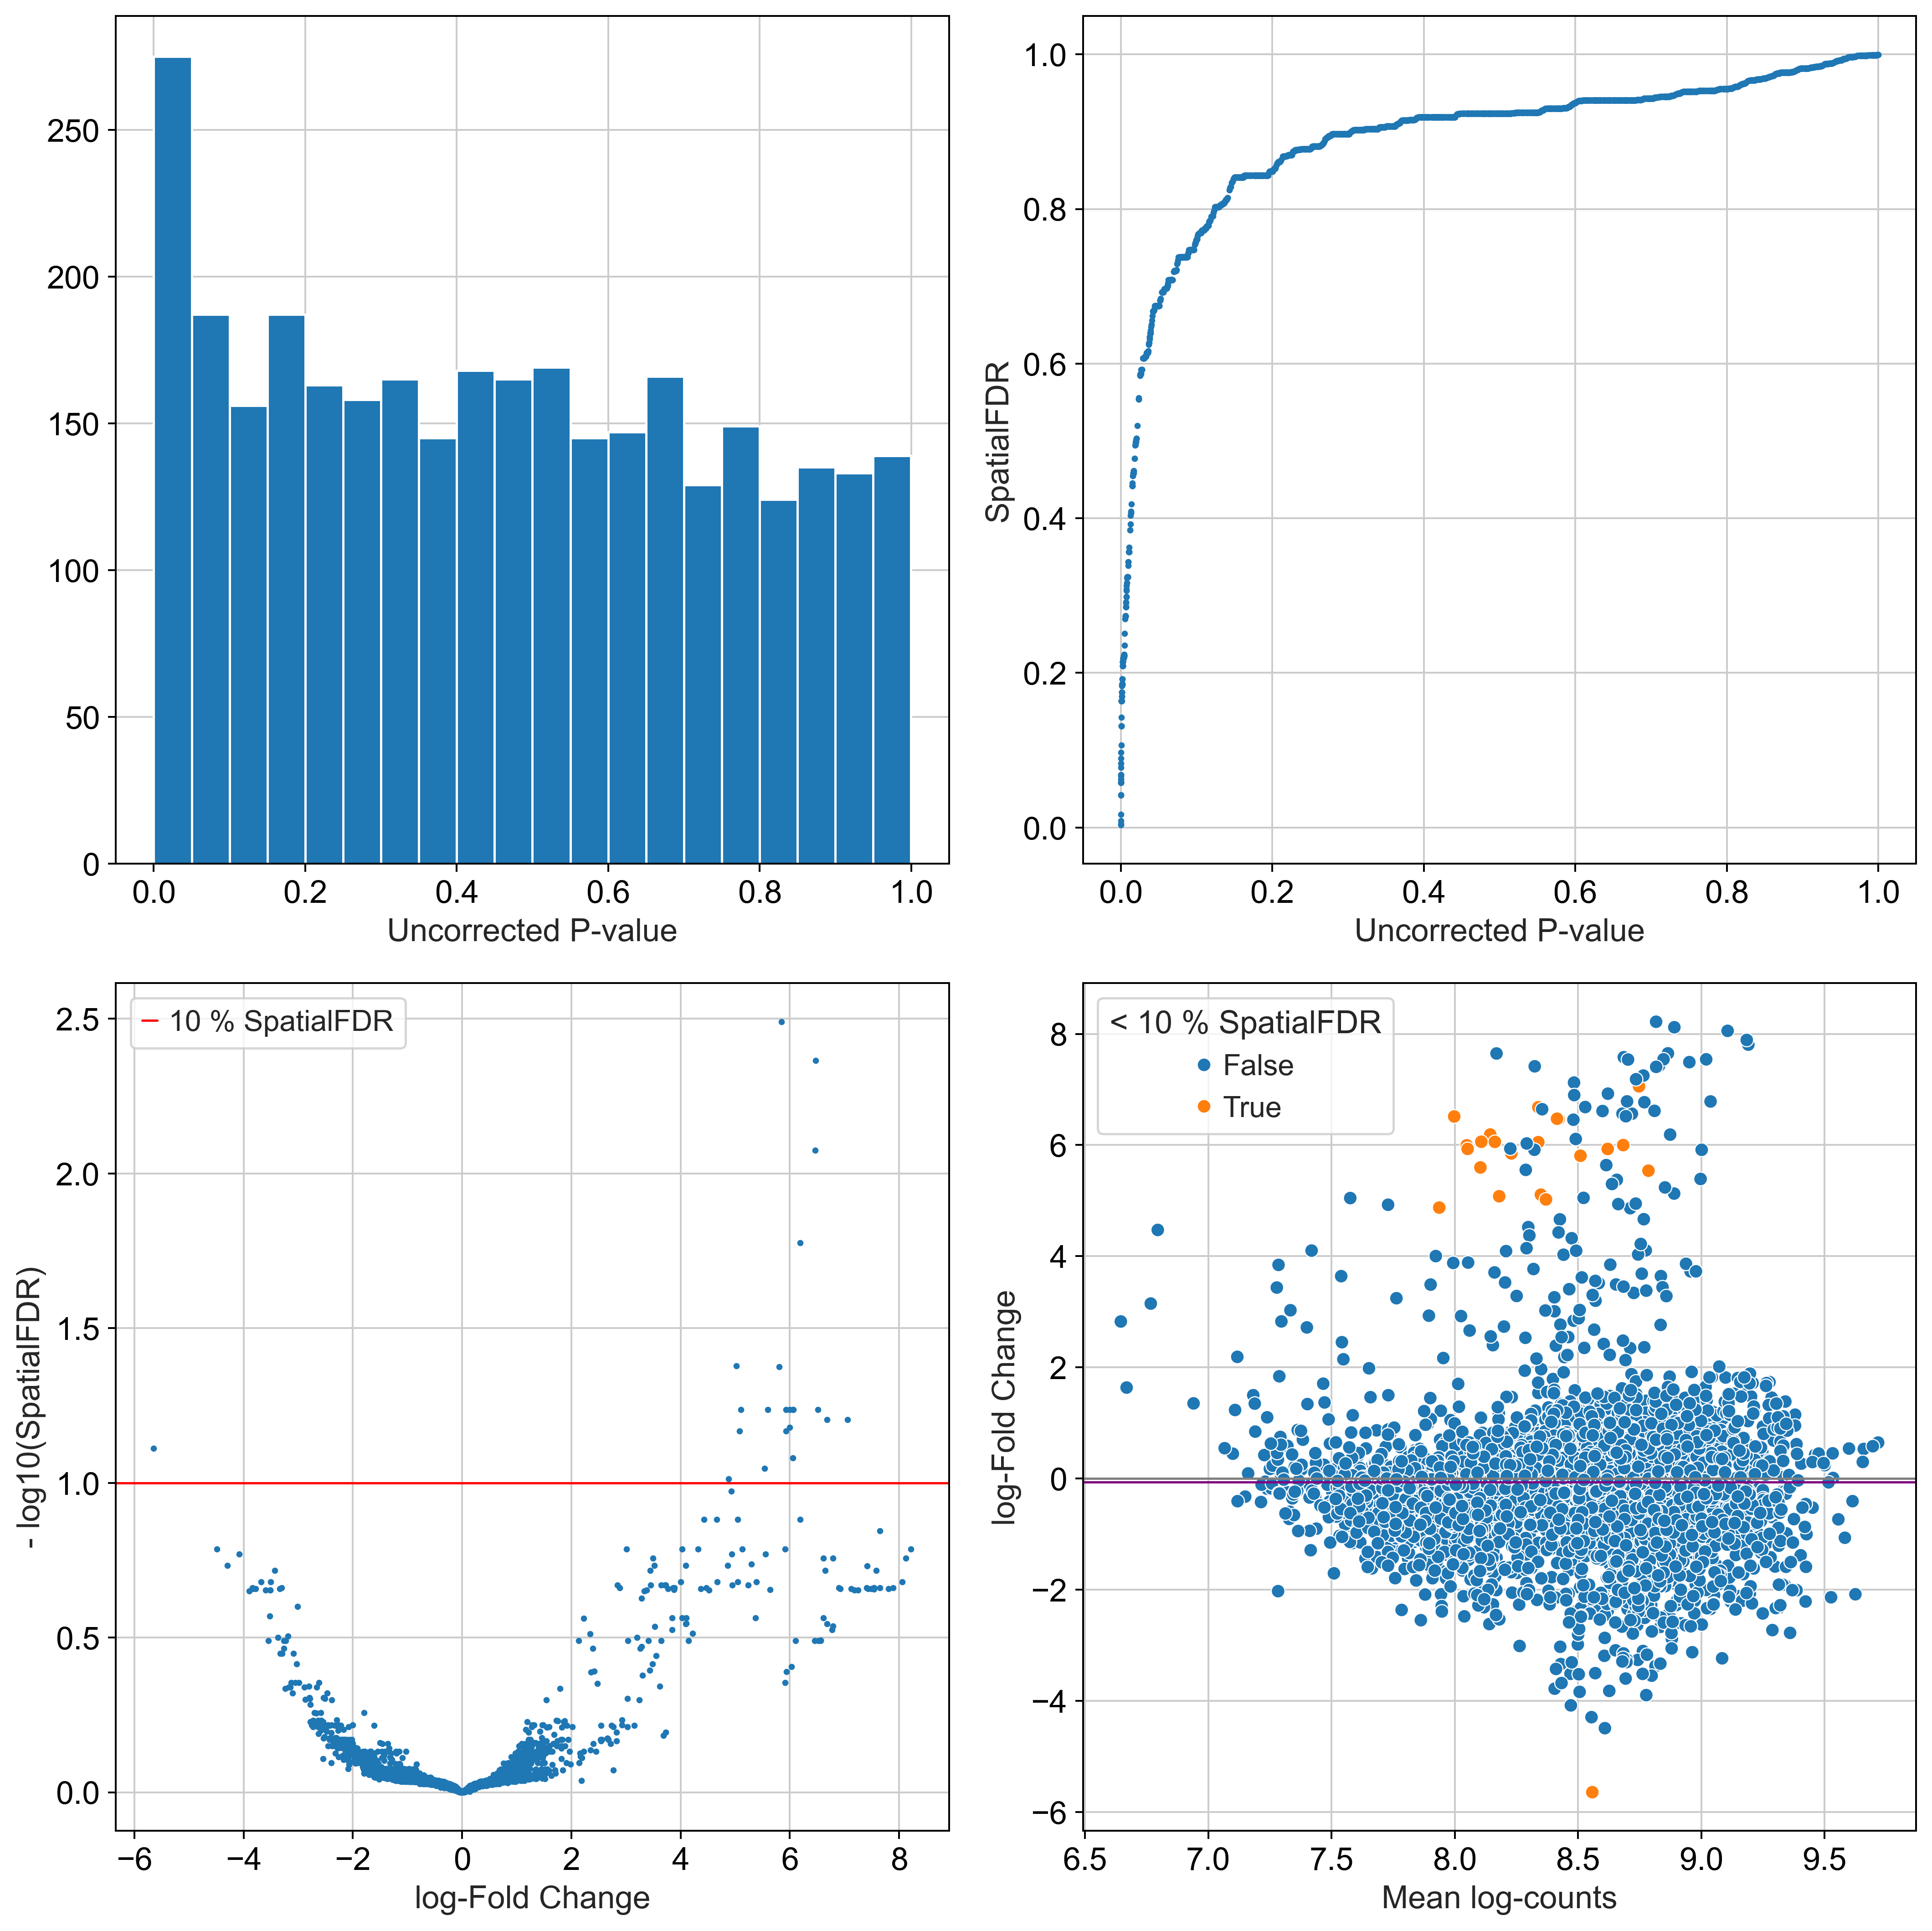

In [19]:
def plot_milo_diagnostics(mdata):
    alpha = 0.1  ## significance threshold

    with plt.rc_context({"figure.figsize": [12, 12]}):

        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(mdata["milo"].var["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(
            mdata["milo"].var["PValue"],
            mdata["milo"].var["SpatialFDR"],
            s=3,
        )
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            mdata["milo"].var["logFC"],
            -np.log10(mdata["milo"].var["SpatialFDR"]),
            s=3,
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = mdata["milo"].var
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()


plot_milo_diagnostics(mdata)

## Plotting of log fold change in cell compartments

In [20]:
mdata

MuData object with n_obs × n_vars = 41716 × 16060
  2 modalities
    rna:	41716 x 16060
      obs:	'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'gene_ids-DMD_immune-DMD', 'feature_types-DMD_immune-DMD', 'genome-DMD_immune-DMD', 'mt-DMD_immune-DMD', 'ribo-DMD_immune-DMD', 'n_cells_by_counts-DMD_immune-DMD', 'mean_counts-DMD_immune-DMD', 'pct_dropout_by_counts-DMD_immune-DMD', 'total_counts-DMD_immune-DMD', 'vst.mean-MDX_MPC-DMD', 'vst.variance-MDX_MPC-DMD', 'vst.variance.expected-MDX_MPC-DMD', 'vst.variance.standardized-MDX_MPC-DMD', 'vst.variable-MDX_MPC-DMD', 'vst.mean-MDX_POOL_NEW-DMD', 'vst.variance-MDX_POOL_NEW-DMD', 'vst.variance.expected-MDX_POOL_NEW-DMD', 'vst.variance.standardized-MDX_POOL_NEW-DMD', 'vst.variable-MDX_POOL_NEW-DMD', 'vst.mean-MDX_MPC', 'vst.variance-MDX_MPC', 'vst.variance.expected-MDX_MPC', 'vst.variance.standardized-MDX_MPC', 'vst.variable-MDX_MPC', 'vst.mean-MDX_POOL_NEW', 'vst.variance-MDX_POOL_NEW', 'vst.variance.expected-MDX_POOL_NEW', 'vst.variance.standardized-MDX_POOL_NEW', 'vst.variable-MDX_POOL_NEW', 'name-pbmc_meyer'
      uns:	'C_scANVI_S1_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_source_colors', 'genotype_colors', 'hvg', 'neighbors', 'sample_colors', 'seed_labels_colors', 'umap', 'nhood_neighbors_key', 'milo'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', 'nhoods'
      obsp:	'distances', 'connectivities', 'milo_distances', 'milo_connectivities'
    milo:	21 x 3205
      obs:	'genotype', 'sample'
      var:	'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR', 'Sig'
      uns:	'sample_col'

In [21]:
milo.build_nhood_graph(mdata)

In [22]:
mdata_milo = mdata.copy()
mdata_milo

MuData object with n_obs × n_vars = 41737 × 19265
  2 modalities
    rna:	41716 x 16060
      obs:	'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'gene_ids-DMD_immune-DMD', 'feature_types-DMD_immune-DMD', 'genome-DMD_immune-DMD', 'mt-DMD_immune-DMD', 'ribo-DMD_immune-DMD', 'n_cells_by_counts-DMD_immune-DMD', 'mean_counts-DMD_immune-DMD', 'pct_dropout_by_counts-DMD_immune-DMD', 'total_counts-DMD_immune-DMD', 'vst.mean-MDX_MPC-DMD', 'vst.variance-MDX_MPC-DMD', 'vst.variance.expected-MDX_MPC-DMD', 'vst.variance.standardized-MDX_MPC-DMD', 'vst.variable-MDX_MPC-DMD', 'vst.mean-MDX_POOL_NEW-DMD', 'vst.variance-MDX_POOL_NEW-DMD', 'vst.variance.expected-MDX_POOL_NEW-DMD', 'vst.variance.standardized-MDX_POOL_NEW-DMD', 'vst.variable-MDX_POOL_NEW-DMD', 'vst.mean-MDX_MPC', 'vst.variance-MDX_MPC', 'vst.variance.expected-MDX_MPC', 'vst.variance.standardized-MDX_MPC', 'vst.variable-MDX_MPC', 'vst.mean-MDX_POOL_NEW', 'vst.variance-MDX_POOL_NEW', 'vst.variance.expected-MDX_POOL_NEW', 'vst.variance.standardized-MDX_POOL_NEW', 'vst.variable-MDX_POOL_NEW', 'name-pbmc_meyer'
      uns:	'C_scANVI_S1_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_source_colors', 'genotype_colors', 'hvg', 'neighbors', 'sample_colors', 'seed_labels_colors', 'umap', 'nhood_neighbors_key', 'milo'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', 'nhoods'
      obsp:	'distances', 'connectivities', 'milo_distances', 'milo_connectivities'
    milo:	21 x 3205
      obs:	'genotype', 'sample'
      var:	'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR', 'Sig', 'Nhood_size'
      uns:	'sample_col', 'nhood'
      varm:	'X_milo_graph'
      varp:	'nhood_connectivities'

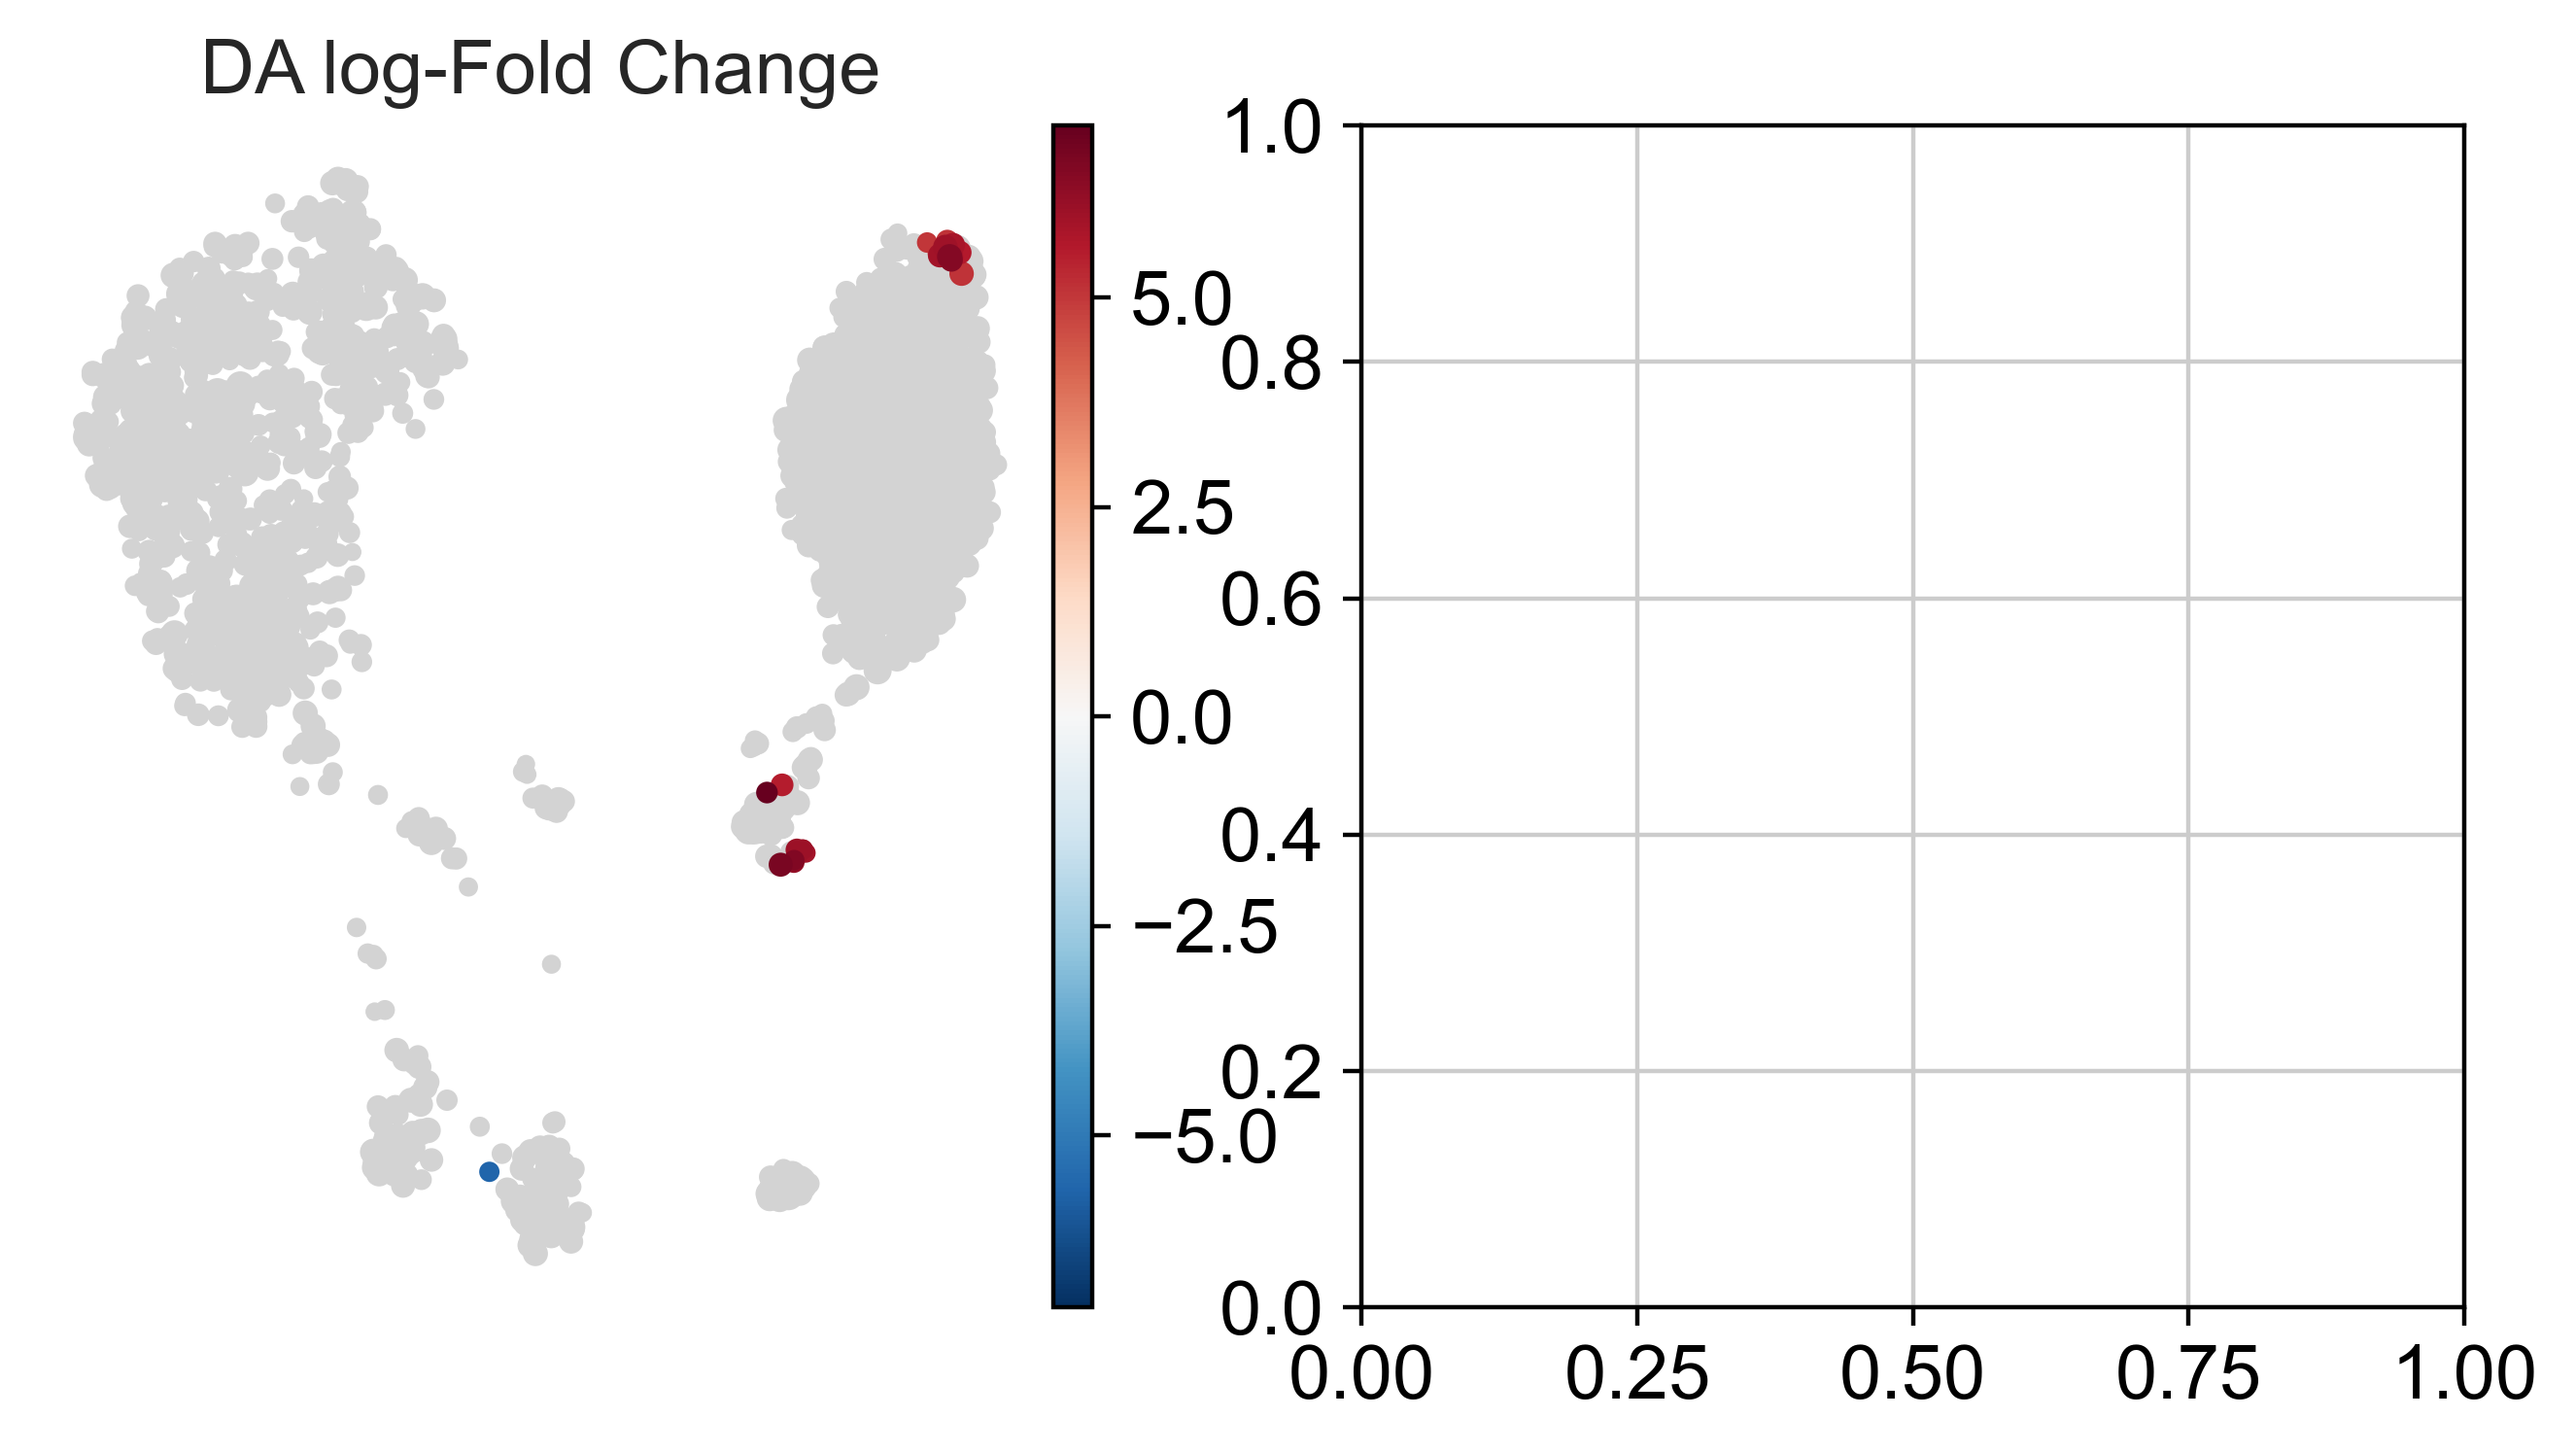

/Users/cartalop/miniforge3/envs/milopy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:455: UserWarning: Adding colorbar to a different Figure <Figure size 1600x800 with 4 Axes> than <Figure size 1600x800 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(


<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

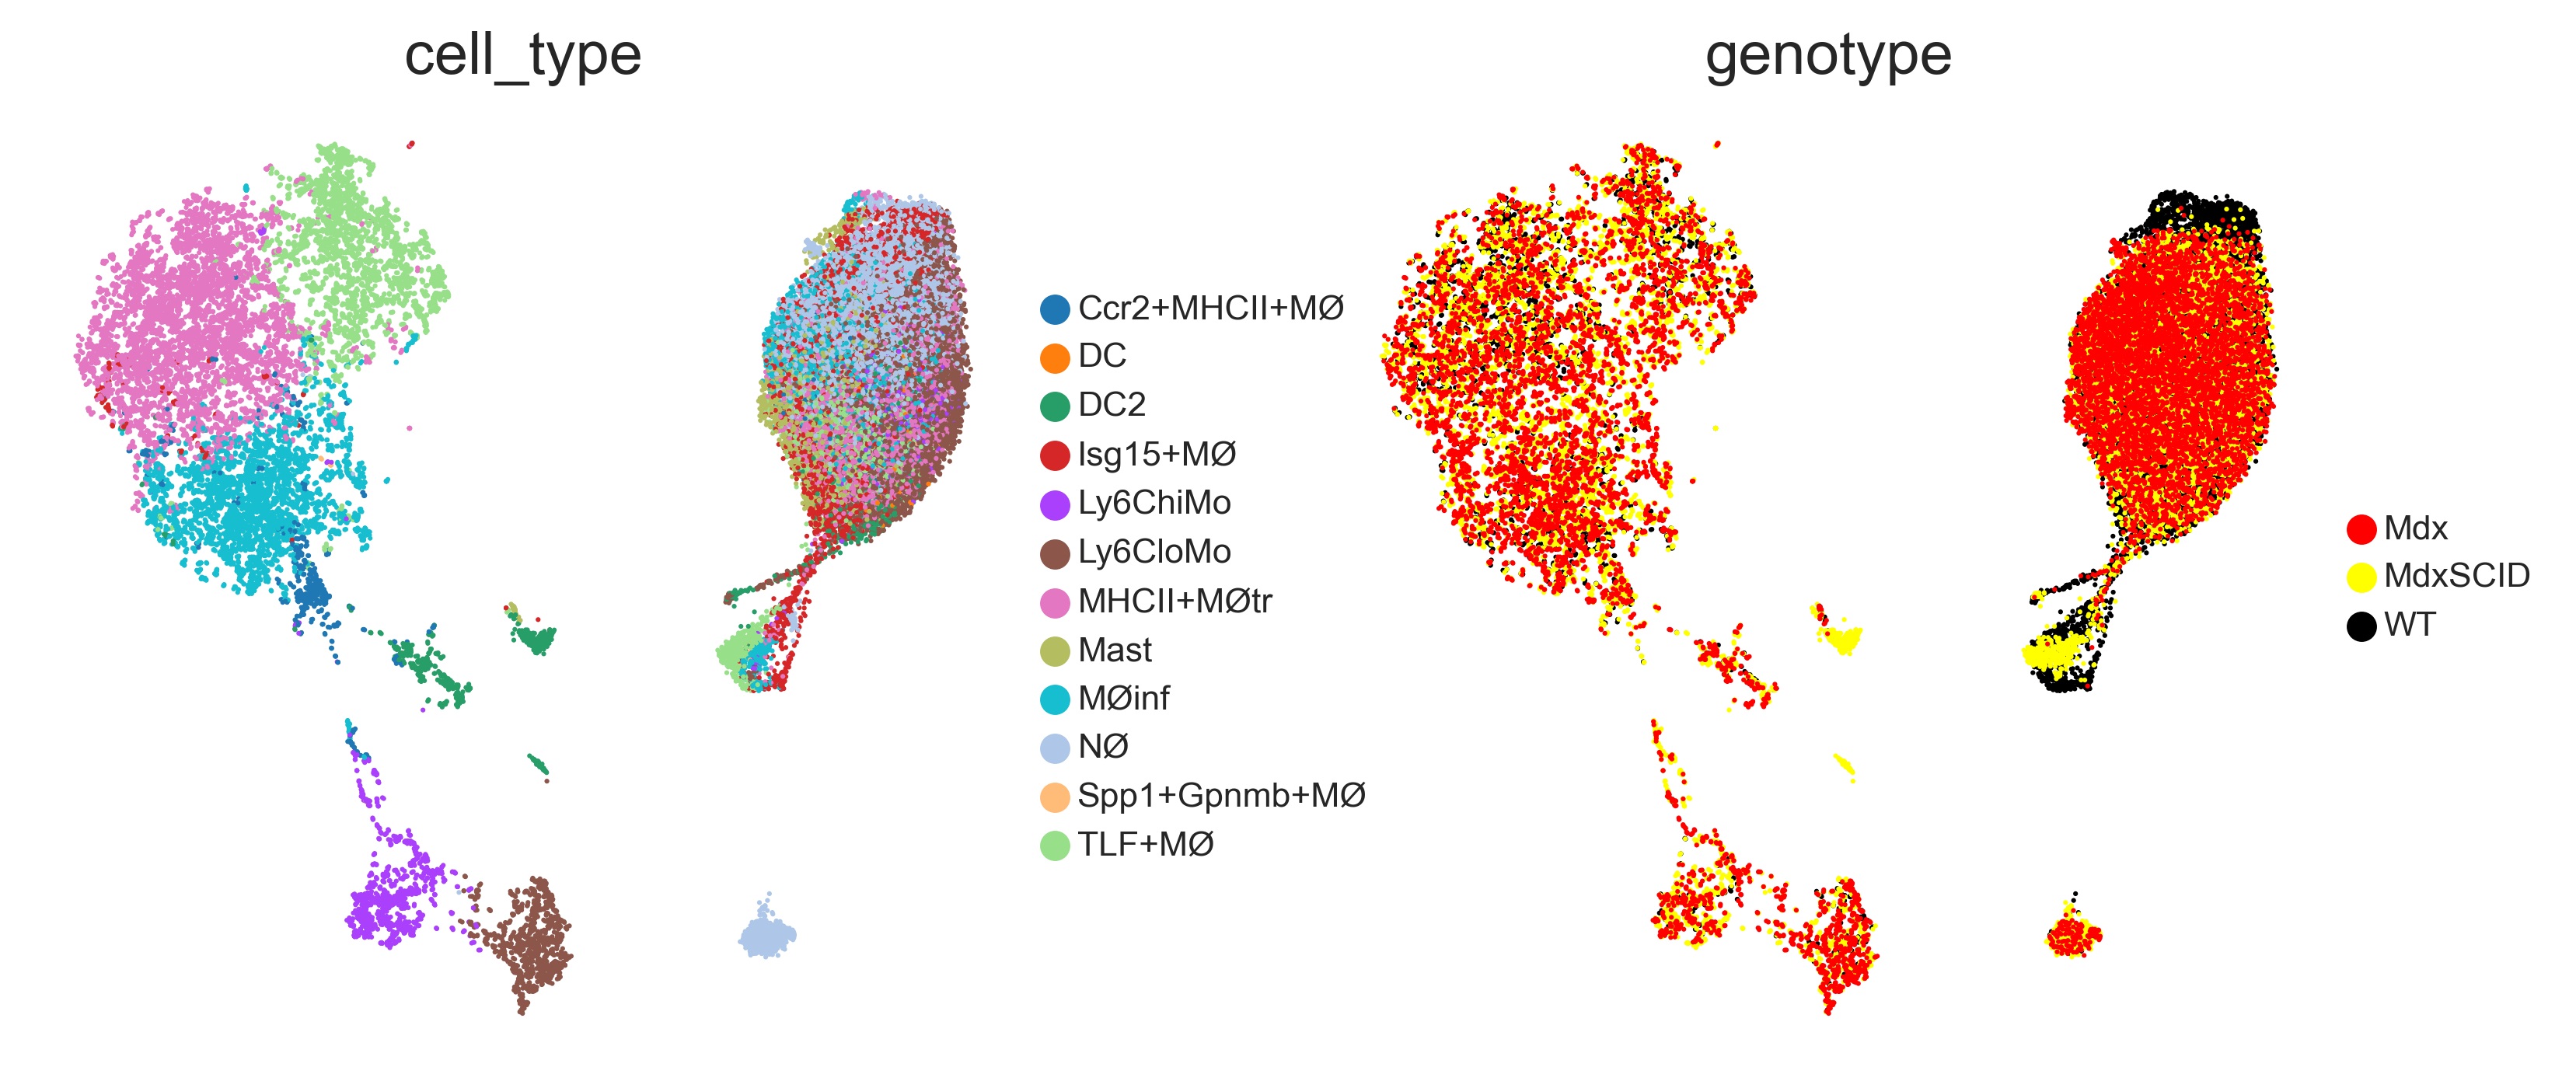

In [23]:
sc.settings.set_figure_params(dpi=200)
milo.build_nhood_graph(mdata)

with plt.rc_context({"figure.figsize": [8, 4]}):
    # Create subplots for each logFC column
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    # Plot neighborhood graph for logFC.1
    milo.plot_nhood_graph(mdata, alpha=0.1, min_size=0.3, plot_edges=False, ax=ax1)
    ax1.set_title('Neighborhood Graph (logFC.1)')
    
    # Plot neighborhood graph for logFC.2
    milo.plot_nhood_graph(mdata, alpha=0.1, min_size=0.3, plot_edges=False, ax=ax2)
    ax2.set_title('Neighborhood Graph (logFC.2)')
    
    plt.tight_layout()

sc.pl.umap(mdata["rna"], color=["cell_type", "genotype"], ncols=2, legend_loc="right margin", legend_fontsize=8, frameon=False, size=5)

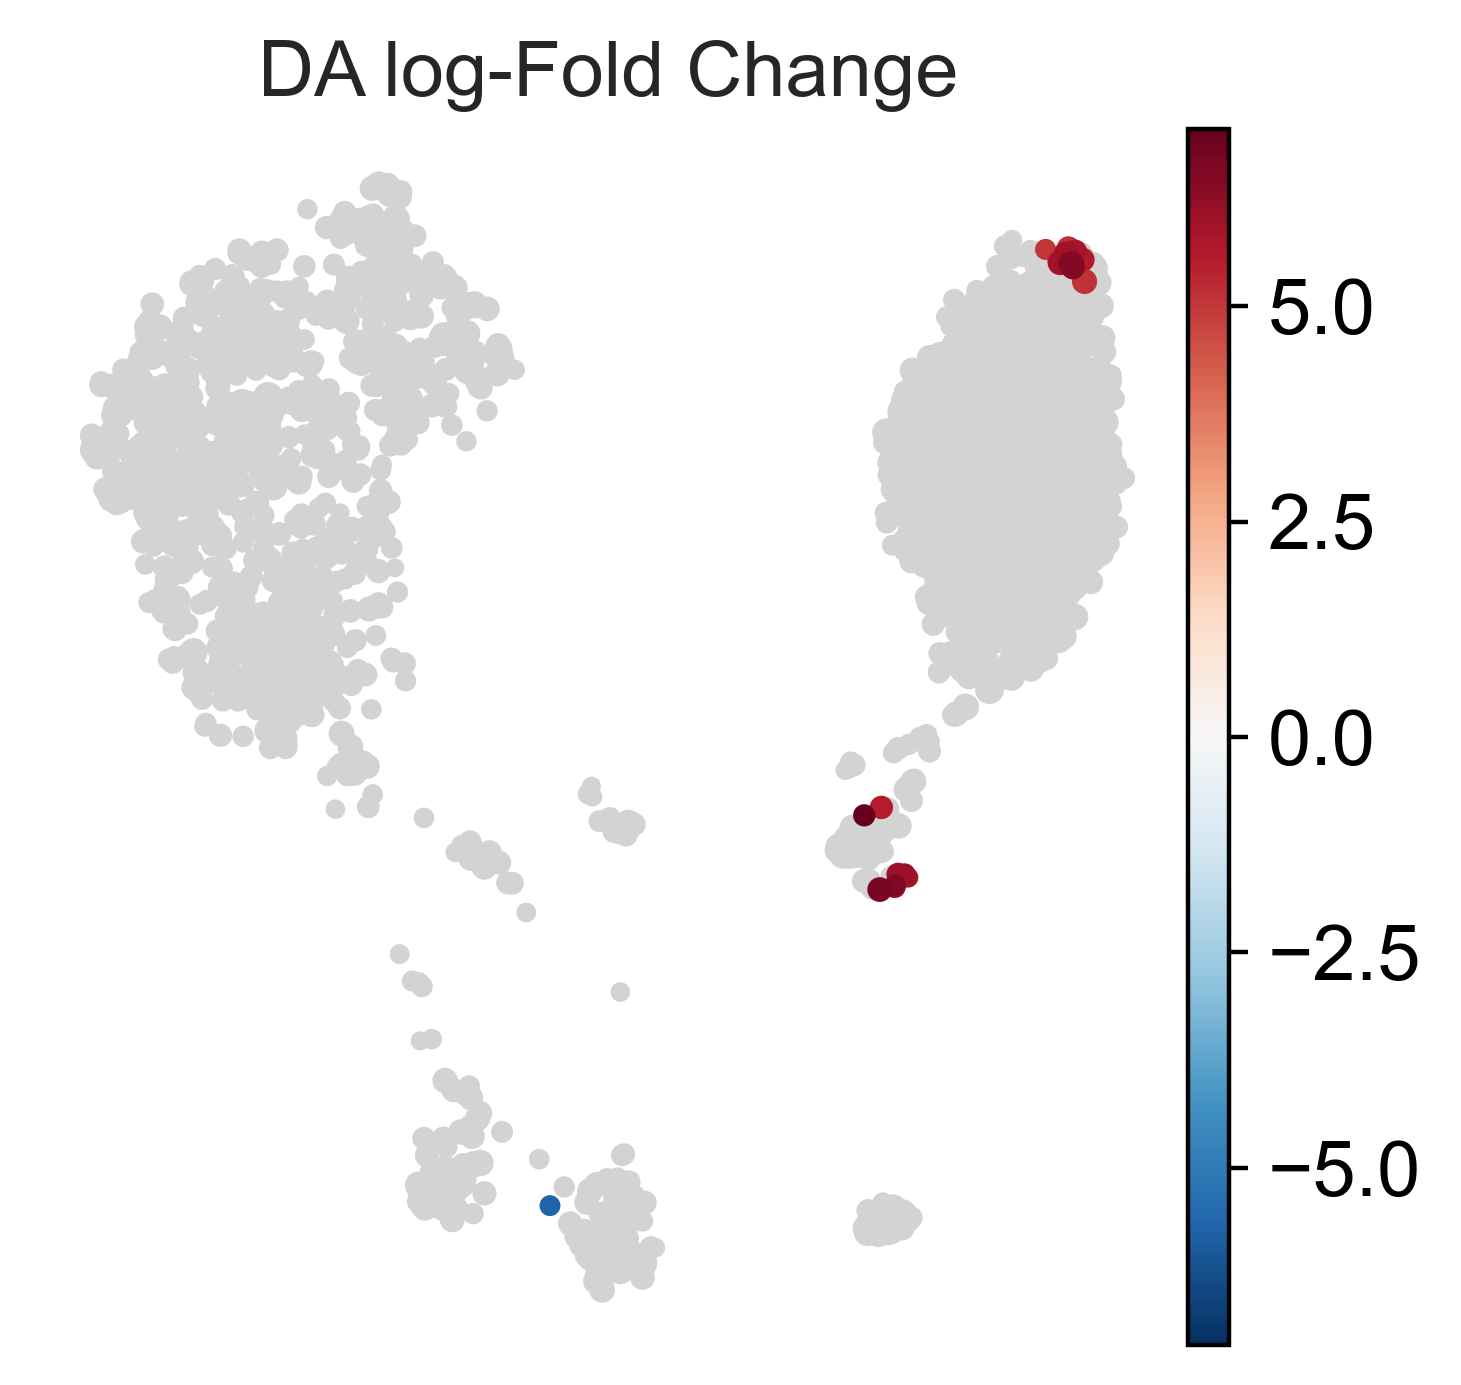

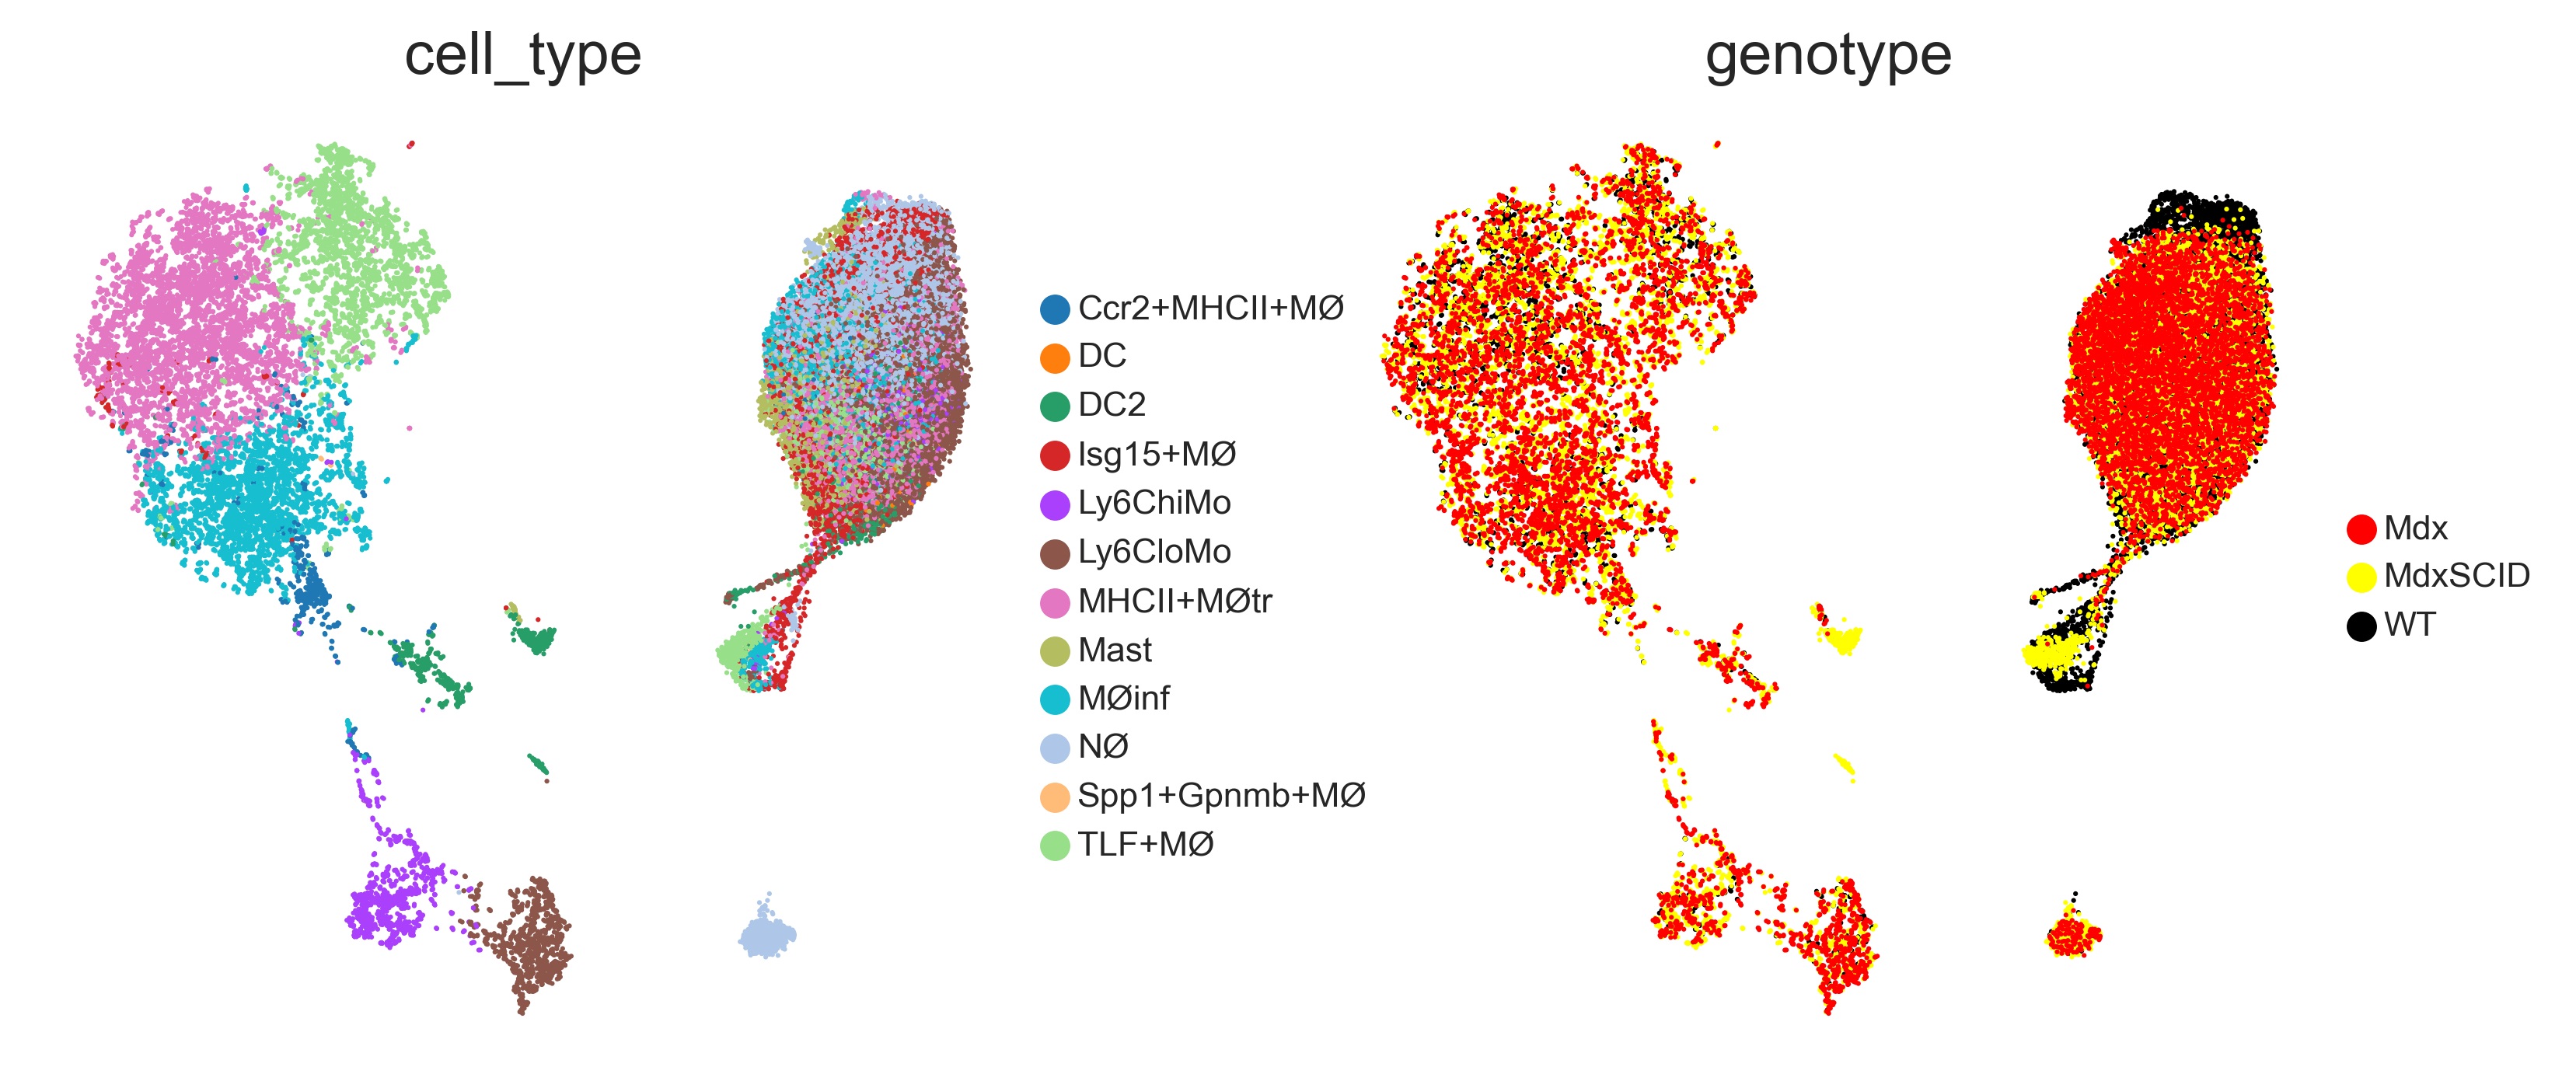

In [24]:
sc.settings.set_figure_params(dpi=200)
milo.build_nhood_graph(mdata)
with plt.rc_context({"figure.figsize": [4, 4]}):
    milo.plot_nhood_graph(mdata, alpha=0.1, min_size=0.3, plot_edges=False,)
    sc.pl.umap(mdata["rna"], color=["cell_type", "genotype"], ncols= 2, legend_loc="right margin", legend_fontsize=8 , frameon= False, size = 5)

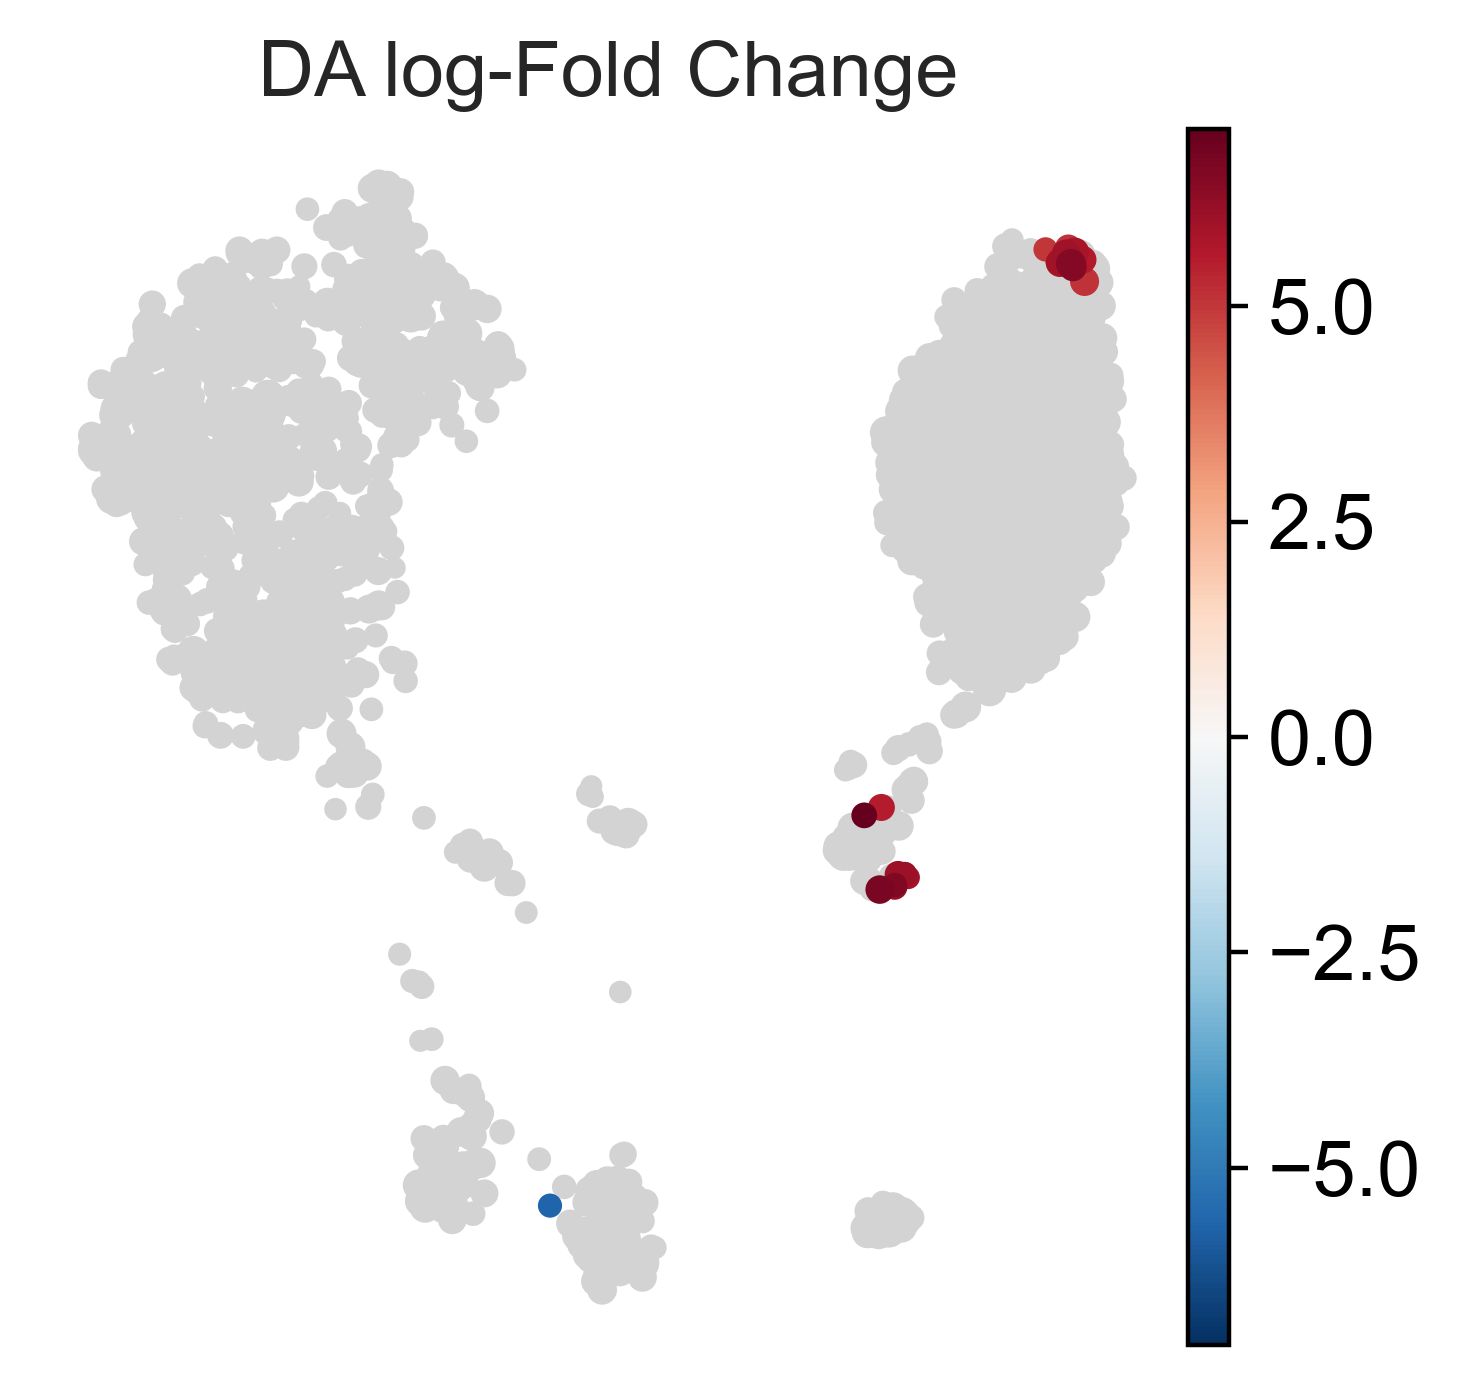

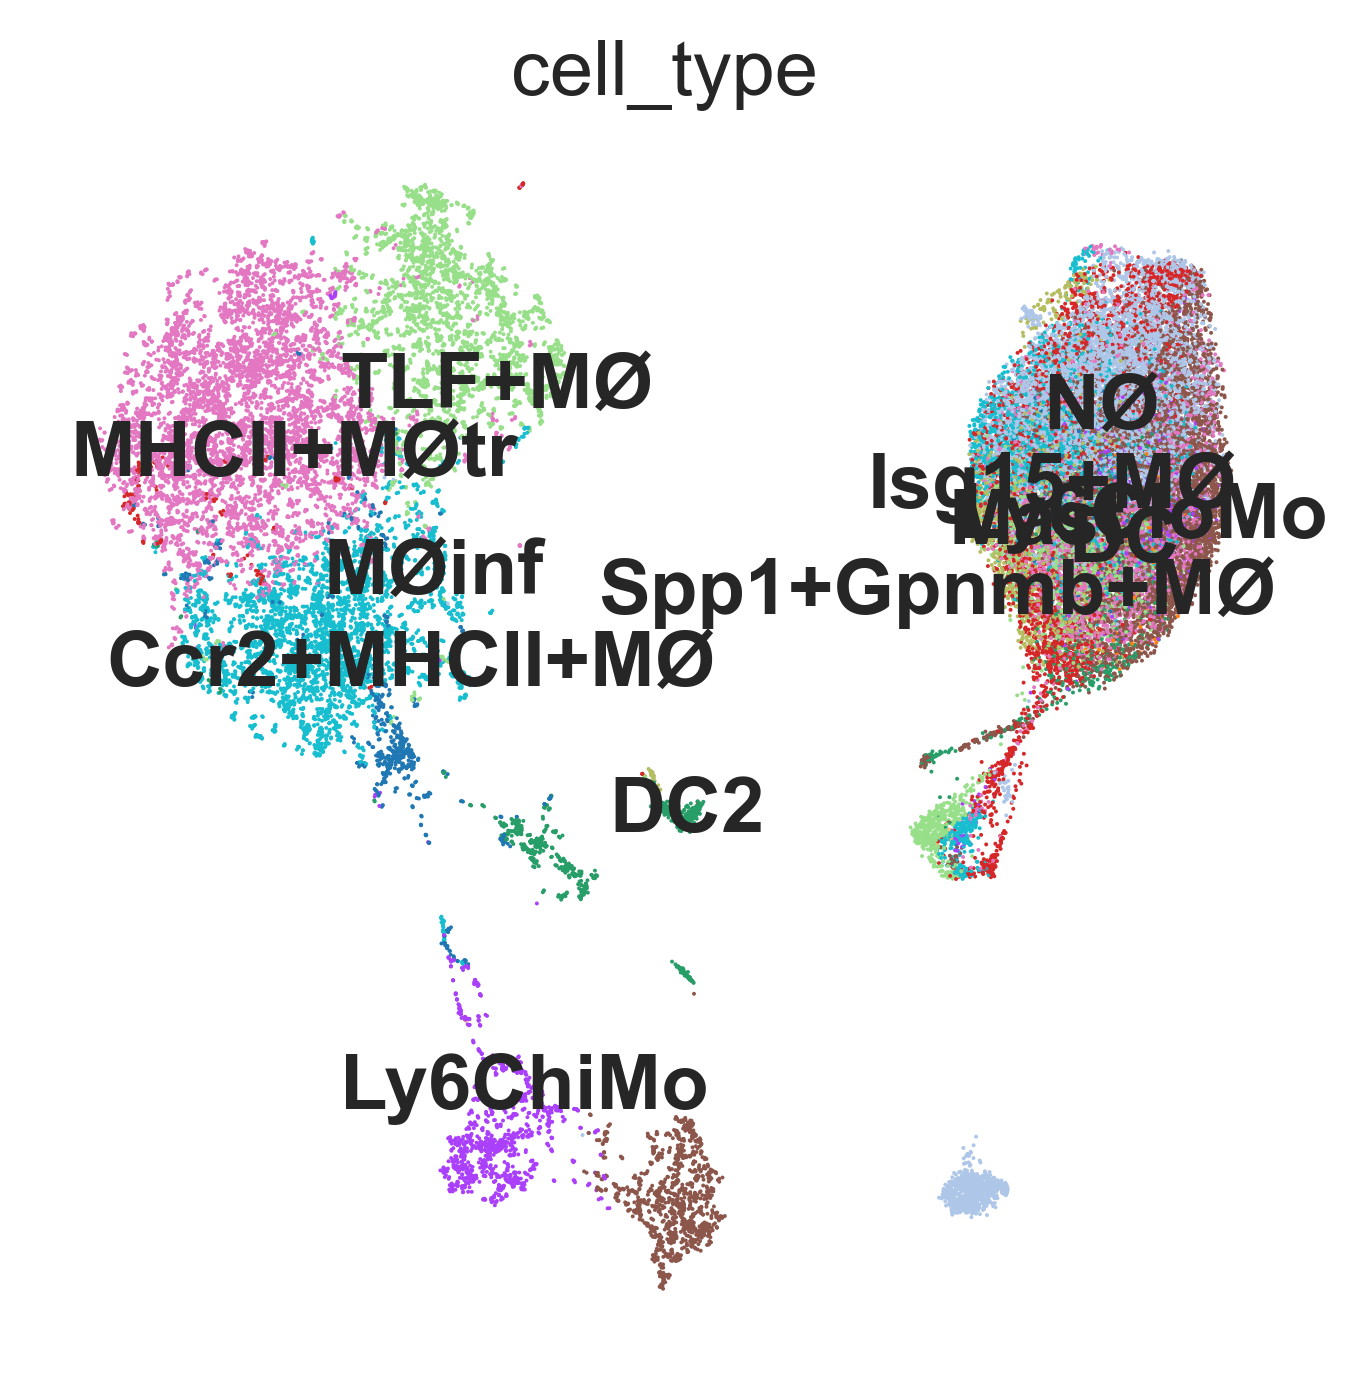

In [25]:
from pertpy.tools import Milo

milo = Milo()

with plt.rc_context({"figure.figsize": [4, 4]}):
    milo.plot_nhood_graph(mdata, alpha=0.1, min_size=0.4, plot_edges=False)
    sc.pl.umap(mdata["rna"], color="cell_type", legend_loc="on data", frameon=False, size=2)

In [26]:

# Define as mixed if fraction of cells in nhood with same label is lower than 0.75
milo.annotate_nhoods(mdata, anno_col="cell_type")
#mdata["milo"].var = mdata["milo"].var.cat.add_categories(['Mixed'])
#mdata["milo"].var.loc[mdata["milo"].var["nhood_annotation_frac"] < 0.75, "nhood_annotation"] = "Mixed"

In [27]:
adata.obs['cell_type'].cat.categories

Index(['Ccr2+MHCII+MØ', 'DC', 'DC2', 'Isg15+MØ', 'Ly6ChiMo', 'Ly6CloMo',
       'MHCII+MØtr', 'Mast', 'MØinf', 'NØ', 'Spp1+Gpnmb+MØ', 'TLF+MØ'],
      dtype='object')

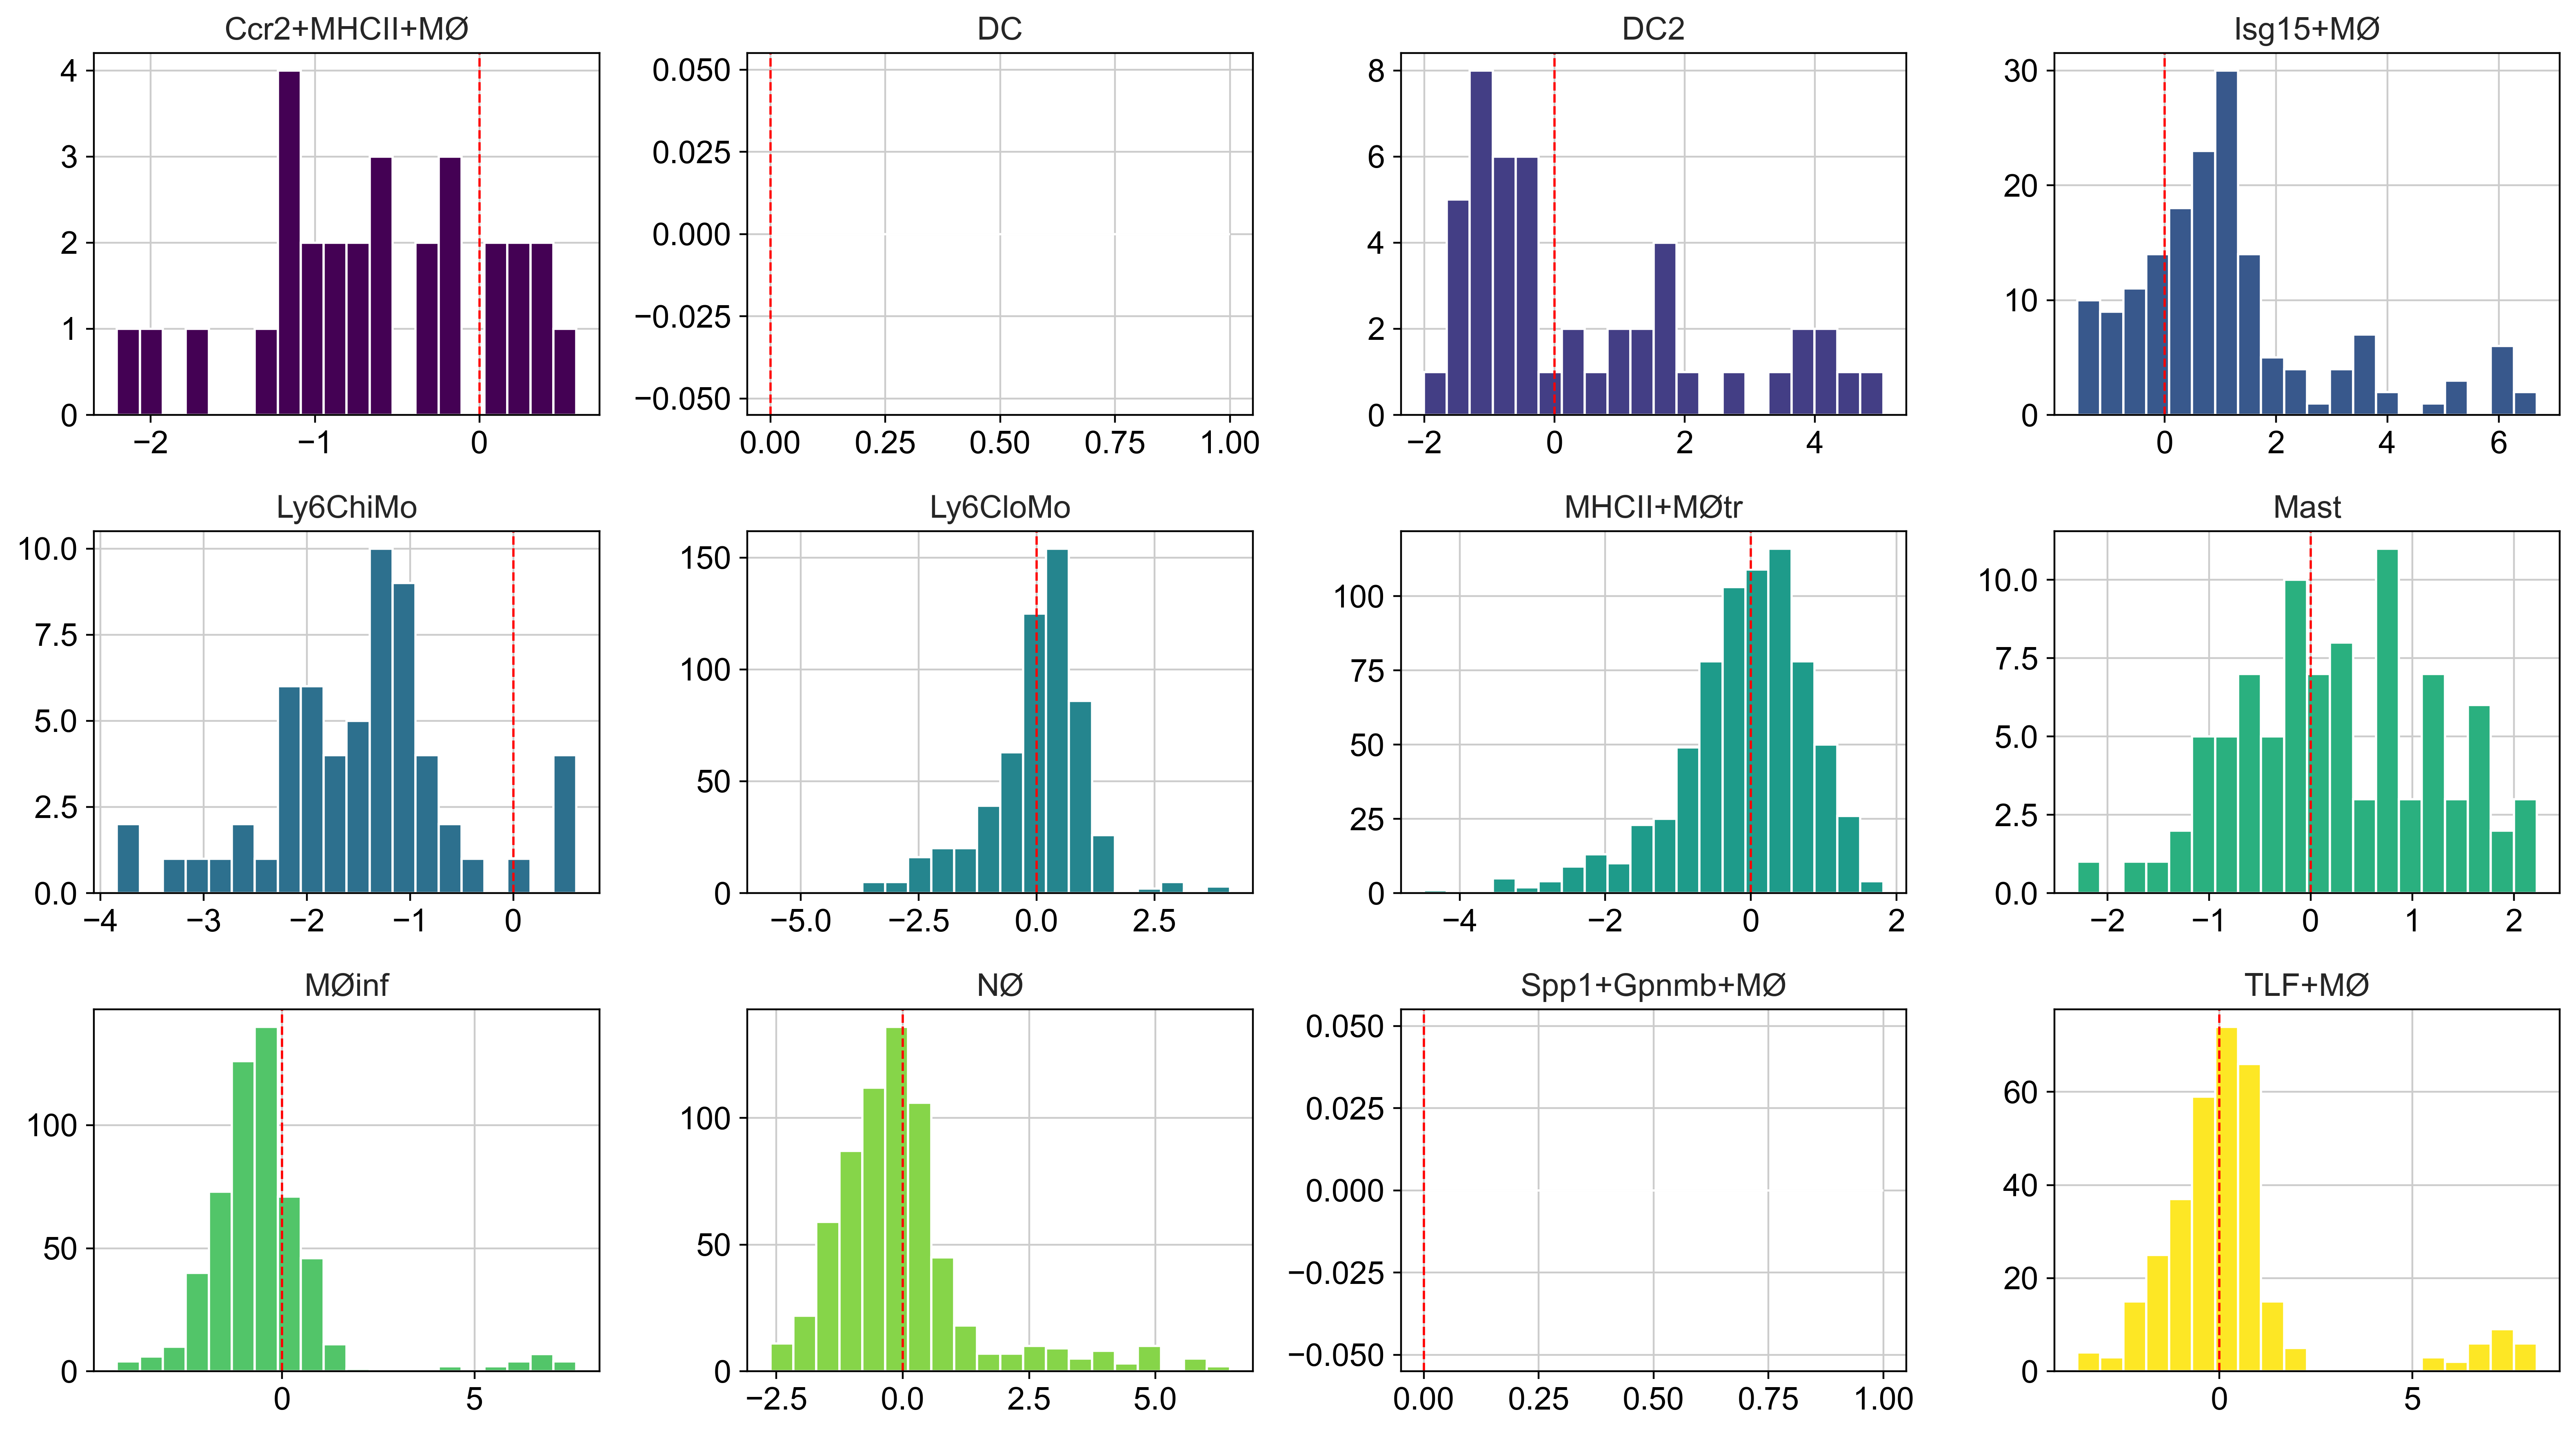

In [28]:
import matplotlib.pyplot as plt
import numpy as np

groups = ['Ccr2+MHCII+MØ', 'DC', 'DC2', 'Isg15+MØ', 'Ly6ChiMo', 'Ly6CloMo',
          'MHCII+MØtr', 'Mast', 'MØinf', 'NØ', 'Spp1+Gpnmb+MØ', 'TLF+MØ']

num_rows = 3
num_cols = 4

fig, axs = plt.subplots(num_rows, num_cols, sharey=False, sharex=False, tight_layout=True, figsize=(16, 9))

colors = plt.cm.viridis(np.linspace(0, 1, len(groups)))

for i, group in enumerate(groups):
    row = i // num_cols
    col = i % num_cols
    
    axs[row, col].hist(mdata["milo"].var[mdata["milo"].var["nhood_annotation"].isin([group])]["logFC"], bins=20, color=colors[i])
    axs[row, col].axvline(x=0, color='r', linewidth=1, linestyle='--')
    axs[row, col].set_title(group)

plt.tight_layout()

In [29]:
def significance_ratios(mdata_object):
    d = {"cell_compartments": [], "significance_ratio": []}
    for i in mdata_object["milo"].var["nhood_annotation"].unique():
        significant = 0
        insignificant = 0
        d["cell_compartments"].append(i)
        for j in mdata_object["milo"].var[mdata_object["milo"].var["nhood_annotation"].isin([i])]["Sig"]:
            if j == True:
                significant += 1
            else:
                insignificant += 1
        d["significance_ratio"].append(significant/(significant+insignificant))
    df = pd.DataFrame.from_dict(data=d)
    return df

In [30]:
mdata['rna'].obs.head()

orig.ident Age_group  BMI COVID_severity  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW        NaN       NaN  NaN            NaN   

                                  COVID_status Ethnicity Group  Sex  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW          NaN       NaN   NaN  NaN   

                                  annotation_broad annotation_detailed  ...  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW              NaN                 NaN  ...   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW              NaN                 NaN  ...   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW              NaN                 NaN  ...   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW              NaN                 NaN  ...   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW              NaN                 NaN  ...   

                                  XIST-counts S_score G2M_score _scvi_batch  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW         NaN     NaN       NaN        28.0   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW         NaN     NaN       NaN        29.0   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW         NaN     NaN       NaN        30.0   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW         NaN     NaN       NaN        27.0   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW         NaN     NaN       NaN        31.0   

                                  _scvi_labels MPC_Annotation compartment  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW         34.0            NaN         DMD   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW         34.0            NaN         DMD   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW         34.0            NaN         DMD   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW         34.0            NaN         DMD   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW         34.0            NaN         DMD   

                                   nhood_ixs_random  nhood_ixs_refined  \
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW                 0                  0   
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW                 0                  0   
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW                 0                  0   
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW                 0                  0   
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW                 1                  0   

                                  nhood_kth_distance  
AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW                0.0  
AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW                0.0  
AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW                0.0  
AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW                0.0  
AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW                0.0  

[5 rows x 49 columns]

In [31]:
significance = significance_ratios(mdata)
significance

cell_compartments  significance_ratio
0            TLF+MØ            0.006079
1                NØ            0.016616
2          Isg15+MØ            0.048780
3              Mast            0.000000
4          Ly6CloMo            0.001748
5               DC2            0.000000
6             MØinf            0.000000
7          Ly6ChiMo            0.000000
8        MHCII+MØtr            0.000000
9     Ccr2+MHCII+MØ            0.000000

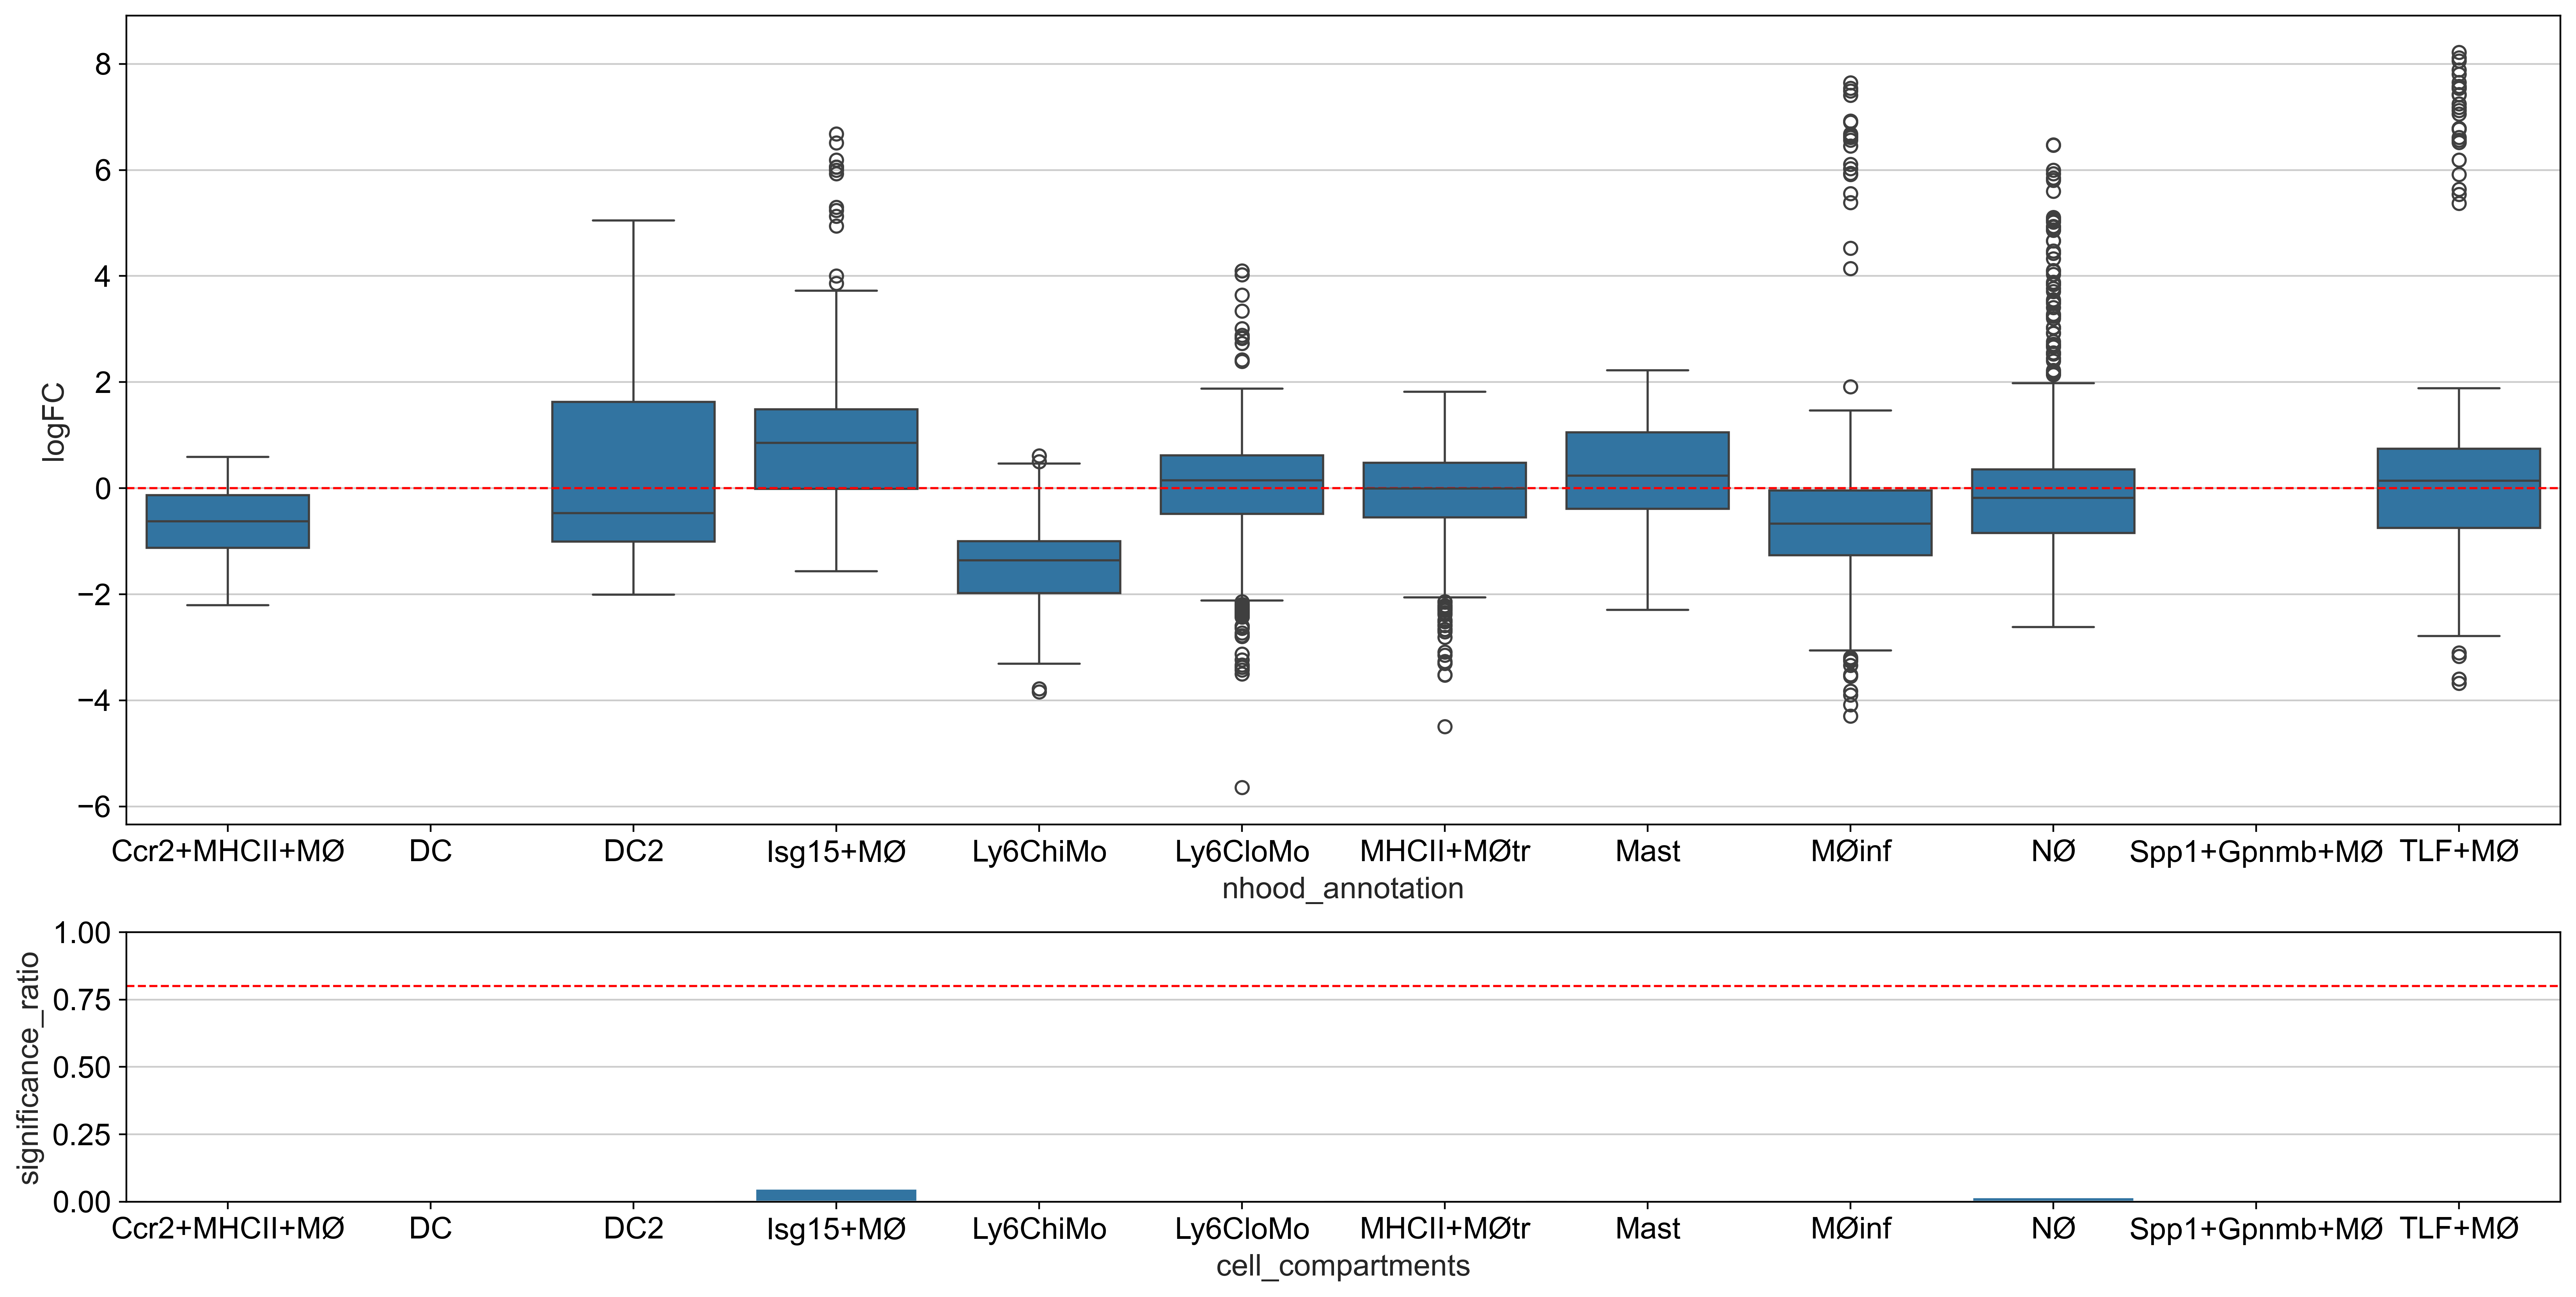

In [35]:
order = ['Ccr2+MHCII+MØ', 'DC', 'DC2', 'Isg15+MØ', 'Ly6ChiMo', 'Ly6CloMo',
          'MHCII+MØtr', 'Mast', 'MØinf', 'NØ', 'Spp1+Gpnmb+MØ', 'TLF+MØ']
fig, axs = plt.subplots(2, figsize=(20,10), gridspec_kw={'height_ratios': [3, 1]})
sns.boxplot(data=mdata["milo"].var, x="nhood_annotation", y="logFC", order=order, ax=axs[0])
axs[0].axhline(y=0, color='r', linewidth=1, linestyle='--')
sns.barplot(data=significance, x="cell_compartments", y="significance_ratio", order=order, ax=axs[1])
plt.ylim(0, 1)
axs[1].axhline(y=0.8, color='r', linewidth=1, linestyle='--')

<Axes: xlabel='nhood_annotation', ylabel='logFC'>

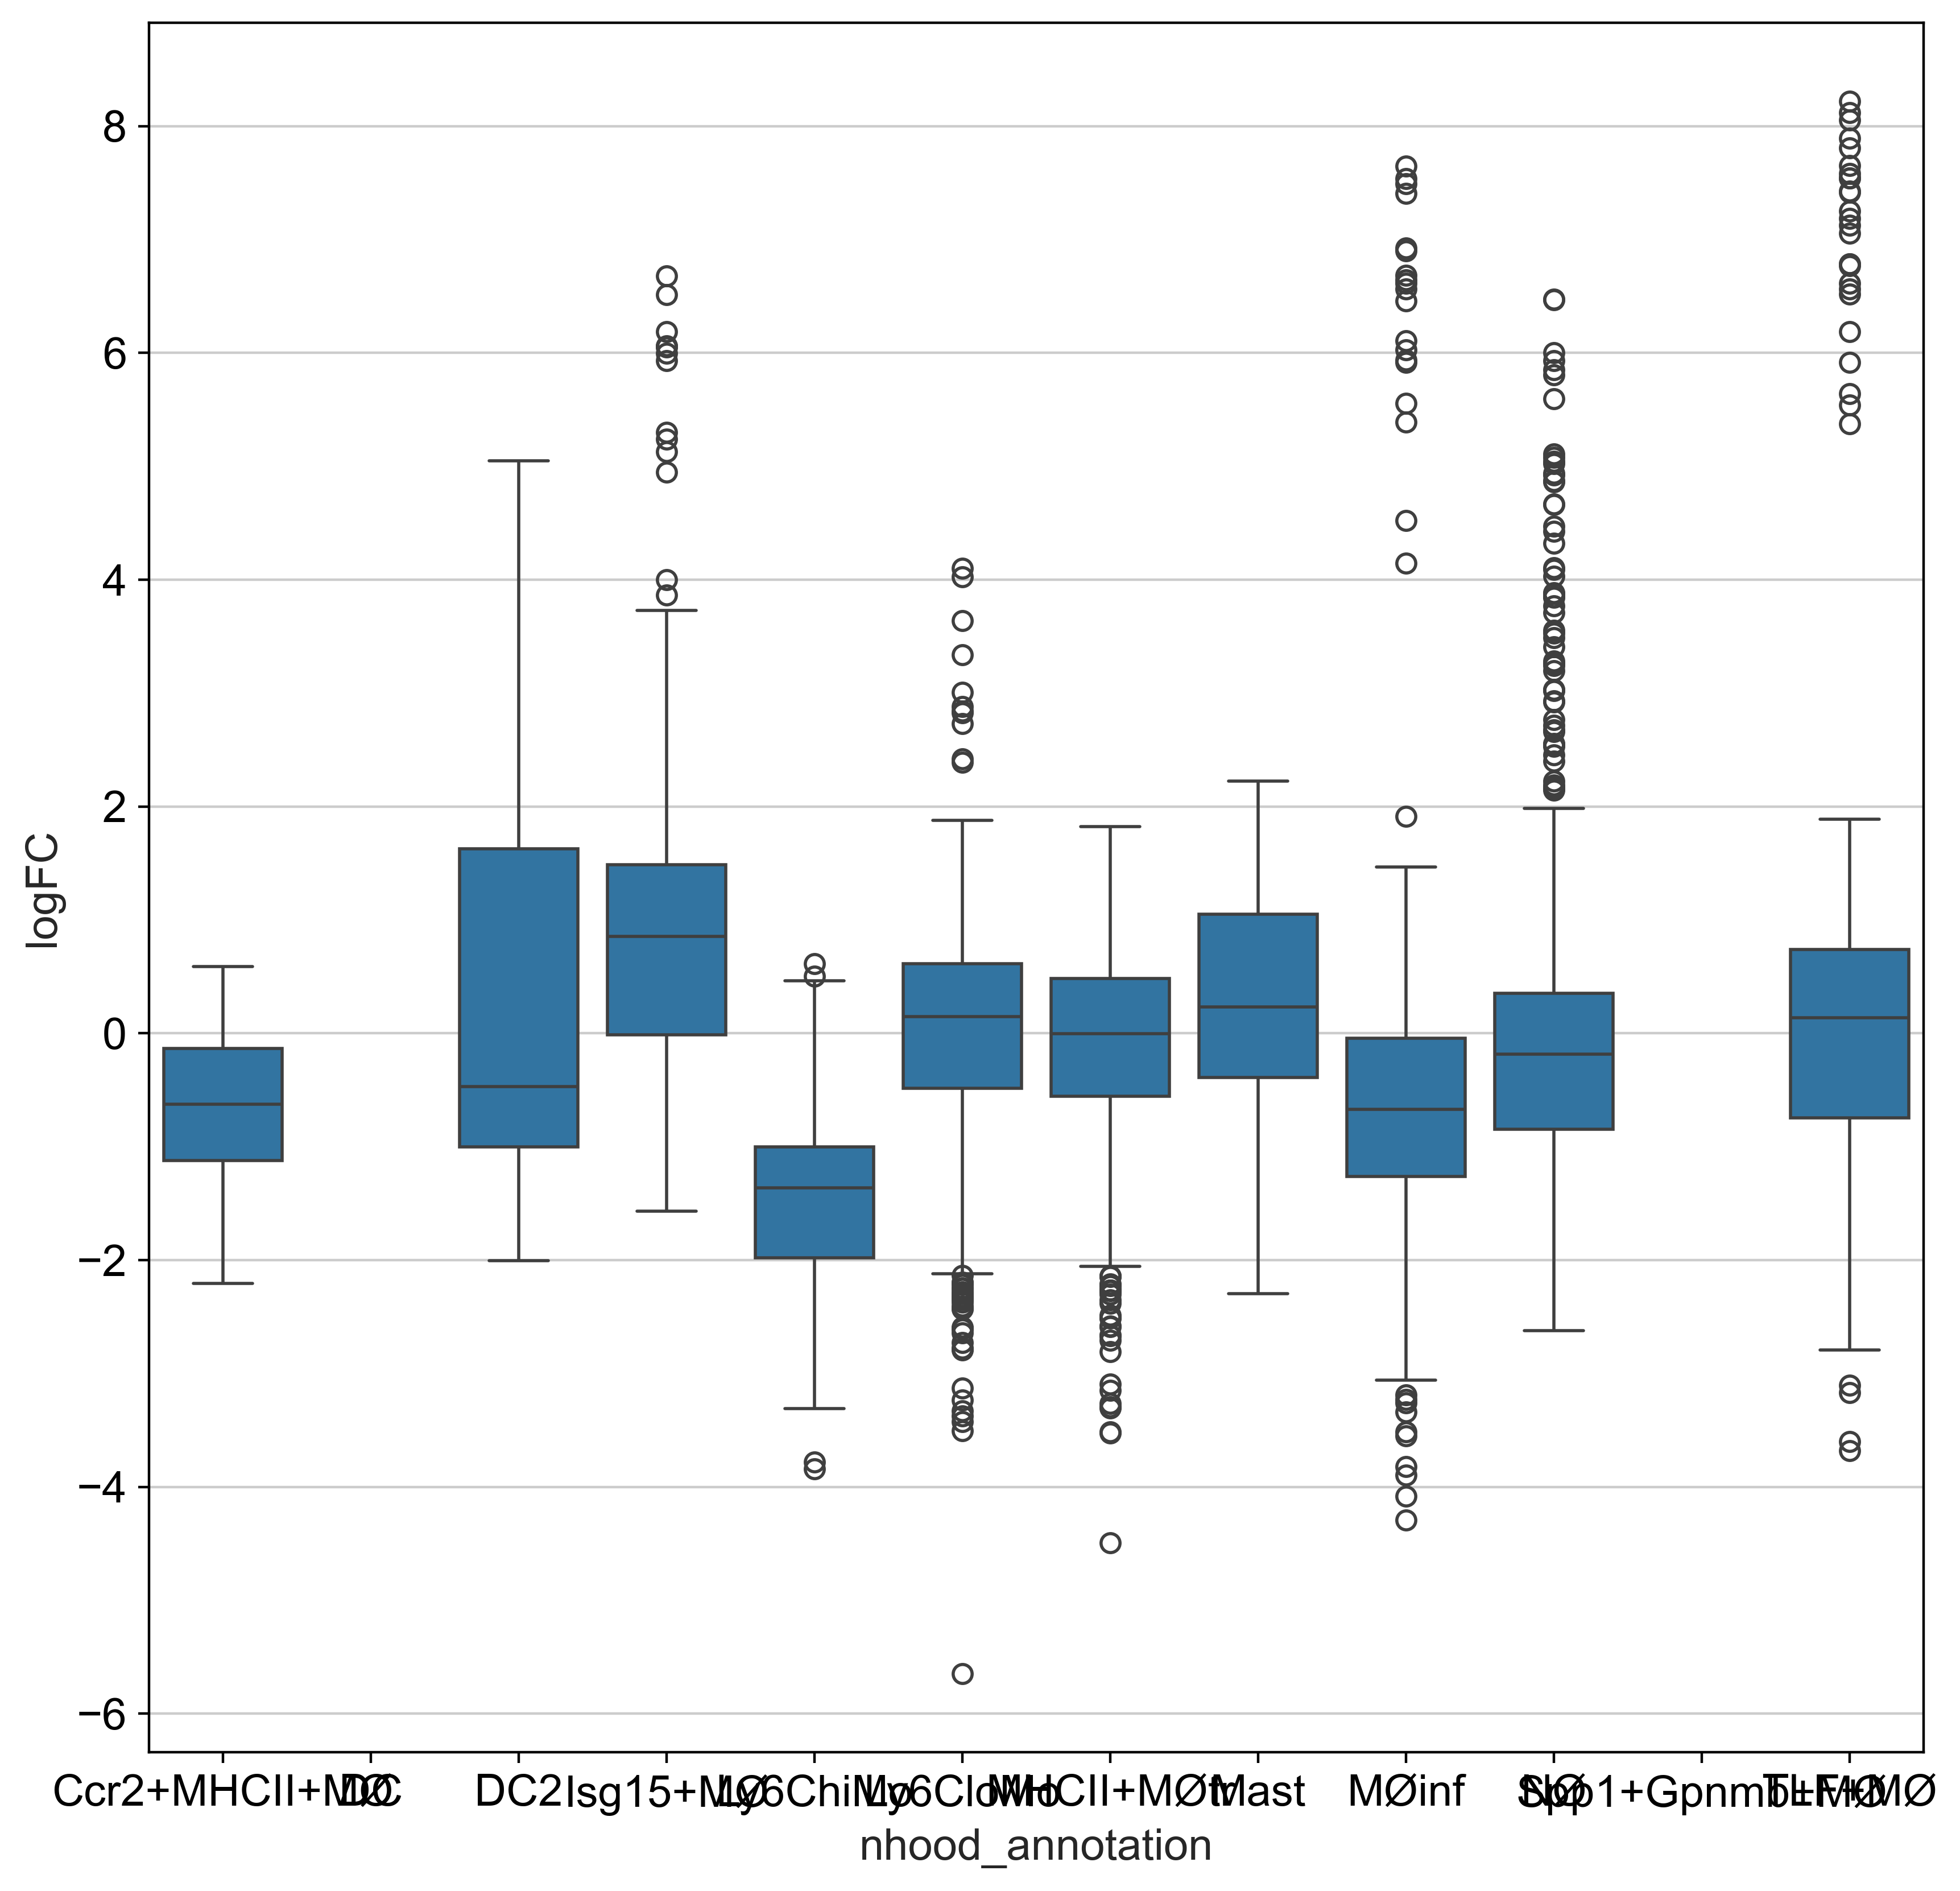

In [33]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=mdata["milo"].var, x="nhood_annotation", y="logFC")

In [34]:
mdata["rna"]

AnnData object with n_obs × n_vars = 41716 × 16060
    obs: 'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
    var: 'gene_ids-DMD_immune-DMD', 'feature_types-DMD_immune-DMD', 'genome-DMD_immune-DMD', 'mt-DMD_immune-DMD', 'ribo-DMD_immune-DMD', 'n_cells_by_counts-DMD_immune-DMD', 'mean_counts-DMD_immune-